In [6]:
from utils import *

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef as phi_coef
import json
from torch import save, load

In [ ]:
def register_performance(train_set:list|tuple, test_set:list|tuple, model, model_name:str, pdict:dict):
        assert (len(train_set)==2) & (len(test_set)==2)

        pred = model.predict(train_set[0])

        pred_proba = model.predict_proba(train_set[0])
        minprob = [1-max(prob) for prob in pred_proba]

        metrics = compute_performance_metrics(train_set[1], pred, pred_proba[:,1])

        print('[Training]')
        print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
        print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
        print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
        pdict[model_name] = {'train': {'1-maxprob':minprob, 'accuracy':metrics[0],
                                    'recall':metrics[1],
                                    'precision':metrics[2], 'f1':metrics[3],
                                    'auroc':metrics[4], 'aupr':metrics[5]}}

        pred = model.predict(test_set[0])

        pred_proba = model.predict_proba(test_set[0])
        minprob = [1-max(prob) for prob in pred_proba]

        metrics = compute_performance_metrics(test_set[1], pred, pred_proba[:,1])

        print('\n[Testing]')
        print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
        print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
        print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
        pdict[model_name]['test'] = {'1-maxprob':minprob, 'accuracy':metrics[0],
                                    'recall':metrics[1],
                                    'precision':metrics[2], 'f1':metrics[3],
                                    'auroc':metrics[4], 'aupr':metrics[5]}

In [ ]:
base_df = pd.DataFrame(columns=['seed', 'model', ''])

In [ ]:
cols = ['age', 'sex', 'chest_pain', 'blood_pressure',
        'cholestoral', 'blood_sugar', 'eletro_results',
        'max_heart_rate', 'exer_angina', 'oldpeak',
        'slope_peak', 'major_vessels', 'thal']

df = pd.read_csv('data/heart/heart.dat', names=cols+['target'], sep=' ')

df['target'] = df['target'].apply(lambda x: 1 if x==2 else 0)

dt_params = {'max_depth':[None,10,20,30],
             'criterion':['gini','entropy','log_loss'],
             'min_samples_split':[2,5,10,20,40,60],
             'min_samples_leaf':[1,2,10,30]}

sgd_params = {
    'loss': ['log_loss', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-4, 1e-3, 1e-2]
}

lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

knn_params = {
    'n_neighbors': list(range(3,21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

model_names = ['dtree', 'sgd', 'lr', 'knn', 'svm_linear', 'svm_poly', 'svm_rbf', 'mlp', 'kan', 'rforest', 'gb', 'adab', 'xgb']
#pred_corrls_mean = pd.DataFrame(0.0, columns=model_names, index=model_names)
pred_corrls_array = None
pred_corrls2_array = None

COUNT = 10
seeds = []
for _ in range(COUNT):
    seed = randint(0, 4294967295)
    seeds.append(seed)

    # 1/3 | 1/3 | 1/3
    BASE_ASSESSOR_SPLIT = 0.3
    BASE_TEST_SIZE = 0.5

    temp = df[df.target==1]
    train_pos, test_pos = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

    temp = df[df.target==0]
    train_neg, test_neg = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

    Xb_train, Xb_test, yb_train, yb_test = train_test_split(pd.concat([train_pos[cols], train_neg[cols]], ignore_index=True), # X
                                                                pd.concat([train_pos['target'], train_neg['target']], ignore_index=True), # y
                                                                test_size=BASE_TEST_SIZE, shuffle=True, random_state=seed)

    scaler = StandardScaler()

    Xb_train_norm = scaler.fit_transform(Xb_train, yb_train)
    Xb_test_norm = scaler.transform(Xb_test)

    # se eu fosse normalizar os dados de teste do assessor, eu usaria o mesmo scaler?

    Xa_test = pd.concat([test_pos[cols], test_neg[cols]], ignore_index=True)
    ya_test = pd.concat([test_pos['target'], test_neg['target']], ignore_index=True)
    Xa_test_norm = scaler.transform(Xa_test)

    """# Base Models"""

    ##performs = {}
    models_error = pd.DataFrame()
    models = []

    """### Decision Tree"""

    #dtree = DecisionTreeClassifier(random_state=seed)#.fit(Xb_train, yb_train)

    g_search = GridSearchCV(DecisionTreeClassifier(random_state=seed), dt_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
    print(g_search.best_params_)
    dtree = g_search.best_estimator_

    #performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), dtree, 'dtree', performs)

    models_error['dtree'] = 1 - dtree.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
    models_error.head()

    models.append(dtree)

    """### Stochastic Gradient Descent
    (SGD)
    """

    #sgd = SGDClassifier(random_state=seed, loss='log_loss', n_jobs=-1).fit(Xb_train_norm, yb_train)


    g_search = GridSearchCV(SGDClassifier(random_state=seed), sgd_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
    print(g_search.best_params_)
    sgd = g_search.best_estimator_

    #performs register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), sgd, 'sgd', performs)
    models_error['sgd'] = 1 - sgd.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
    models.append(sgd)

    """### Logistic Regression"""

    lr = LogisticRegression(random_state=seed, n_jobs=-1).fit(Xb_train_norm, yb_train)

    g_search = GridSearchCV(LogisticRegression(random_state=seed), lr_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
    print(g_search.best_params_)
    lr = g_search.best_estimator_

    #performs register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), lr, 'lr', performs)
    models_error['lr'] = 1 - lr.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
    models.append(lr)

    """### K-Nearest Neighbors

    (KNN)
    """

    #knn = KNeighborsClassifier(n_jobs=-1).fit(Xb_train_norm, yb_train)

    g_search = GridSearchCV(KNeighborsClassifier(), knn_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
    print(g_search.best_params_)
    knn = g_search.best_estimator_

    #performs register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), knn, 'knn', performs)
    models_error['knn'] = 1 - knn.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
    models.append(knn)

    """### Support Vector Machine - Linear
    (SVM)
    """

    #svm_linear = SVC(kernel='linear', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

    svm_linear_params = {
        'C': [0.1, 1, 10]
    }

    g_search = GridSearchCV(SVC(kernel='linear', probability=True, random_state=seed), svm_linear_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
    print(g_search.best_params_)
    svm_linear = g_search.best_estimator_

    #performs register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_linear , 'svm_linear', performs)
    models_error['svm_linear'] = 1 - svm_linear.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
    models.append(svm_linear)

    """### Support Vector Machine - Polynomial
    (SVM)
    """

    #svm_poly = SVC(kernel='poly', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

    svm_poly_params = {
        'C': [0.1, 1, 10],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto']
    }

    g_search = GridSearchCV(SVC(kernel='poly', probability=True, random_state=seed), svm_poly_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
    print(g_search.best_params_)
    svm_poly = g_search.best_estimator_

    #performs register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_poly, 'svm_poly', performs)
    models_error['svm_poly'] = 1 - svm_poly.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
    models.append(svm_poly)

    """### Support Vector Machine - RBF
    (SVM)
    """

    #svm_rbf = SVC(kernel='rbf', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

    svm_rbf_params = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    }

    g_search = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=seed), svm_rbf_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
    print(g_search.best_params_)
    svm_rbf = g_search.best_estimator_

    #performs register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_rbf, 'svm_rbf', performs)
    models_error['svm_rbf'] = 1 - svm_rbf.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
    models.append(svm_rbf)

    """### Multi-Layer Perceptron
    (MLP)
    """

    #mlp = MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed).fit(Xb_train_norm, yb_train)

    mlp_params = {
        'hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001]
    }

    g_search = GridSearchCV(MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed), mlp_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
    print(g_search.best_params_)
    mlp = g_search.best_estimator_

    #performs register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), mlp, 'mlp', performs)
    models_error['mlp'] = 1 - mlp.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
    models.append(mlp)

    """### Kolmogorov-Arnold Network
    (KAN)
    """

    #kan_cv = int(input('Rodar CV da KAN? (0-Não / 1-Sim): '))

    '''dataset = {'train_input': Xb_train_norm,
            'train_label': yb_train,
            'test_input': Xb_test_norm,
            'test_label': yb_test}'''

    #best_width = [13,5,5,2]

    kan_params = {'width': [[13,2,2,2], [13,3,2], [13,20,2]],
                'grid': [3, 6, 8],
                'lr': [0.0001, 0.001],
                'lamb': [0.005, 0.1]}

    best_score = 0
    for w in kan_params['width']:
        for g in kan_params['grid']:
            for lr in kan_params['lr']:
                for l in kan_params['lamb']:
                    score = cross_val_score(KANClassifier(w, grid=g, lr=lr, lamb=l, random_state=seed, grid_eps=1, steps=15), X=Xb_train_norm, y=yb_train, cv=5, error_score=0).mean()
                    if(score > best_score):
                        best_score = score
                        best_width = w
                        best_grid = g
                        best_lr = lr
                        best_lamb = l
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15).fit(Xb_train_norm, yb_train)
    with open(f'kan_params/heart{seed}.json', 'w') as f:
        json.dump({'width': best_width, 'grid': best_grid, 'lr': best_lr, 'lamb': best_lamb}, f)
        #joblib.dump(kanet.state_dict(), 'kan_params/heart.pkl')
    save(kanet.state_dict(), 'kan_params/heart.pt')

    print('width: {},\ngrid: {},\nlr: {},\nlamb: {}'.format(best_width, best_grid, best_lr, best_lamb))

    #performs register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), kanet, 'kan', performs)
    models_error['kan'] = 1 - kanet.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
    models.append(kanet)

    """### Random Forest"""

    #rforest = RandomForestClassifier(random_state=seed, n_jobs=-1).fit(Xb_train, yb_train)

    parameters = {'max_depth':[None,10,20,30],
                'criterion':['gini','entropy','log_loss'],
                'min_samples_split':[2,5,10,20,40,60],
                'min_samples_leaf':[1,2,10,30],
                'n_estimators':[20,50,100,150]}

    g_search = GridSearchCV(RandomForestClassifier(random_state=seed), parameters, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
    print(g_search.best_params_)
    rforest = g_search.best_estimator_

    #performs register_performance((Xb_train, yb_train), (Xb_test, yb_test), rforest, 'rforest', performs)
    models_error['rforest'] = 1 - rforest.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
    models.append(rforest)

    """### Gradient Boosting"""

    #gb = GradientBoostingClassifier(random_state=seed).fit(Xb_train, yb_train)

    gb_params = {'max_depth':[None,10,20,30],
                'criterion':['friedman_mse', 'squared_error'],
                'min_samples_split':[2,5,10,20,40,60],
                'learning_rate': [0.01, 0.05, 0.1],
                'n_estimators':[20,50,100,150]}

    g_search = GridSearchCV(GradientBoostingClassifier(random_state=seed), gb_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
    print(g_search.best_params_)
    gb = g_search.best_estimator_

    #performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), gb, 'gb', performs)
    models_error['gb'] = 1 - gb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
    models.append(gb)

    """### AdaBoost"""

    #adab = AdaBoostClassifier(random_state=seed).fit(Xb_train, yb_train)

    adab_params = {'learning_rate': [0.01, 0.05, 0.1, 1],
                'n_estimators':[20,50,100,150]}

    g_search = GridSearchCV(AdaBoostClassifier(random_state=seed), adab_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
    print(g_search.best_params_)
    adab = g_search.best_estimator_

    #performs register_performance((Xb_train, yb_train), (Xb_test, yb_test), adab, 'adab', performs)
    models_error['adab'] = 1 - adab.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
    models.append(adab)

    """### XGBoost"""

    #xgb = XGBClassifier(random_state=seed).fit(Xb_train, yb_train)

    xgb_params = {
        'n_estimators': [20,50,100,150],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [None,5,10,20,30],
        'gamma': [None, 0.25, 0.5]
    }

    g_search = GridSearchCV(XGBClassifier(random_state=seed), xgb_params, n_jobs=1, cv=5).fit(Xb_train, yb_train)
    print(g_search.best_params_)
    xgb = g_search.best_estimator_

    #performs register_performance((Xb_train, yb_train), (Xb_test, yb_test), xgb, 'xgb', performs)
    models_error['xgb'] = 1 - xgb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test] #xgb.predict(Xb_test) != yb_test
    models.append(xgb)

    """## Análise de Correlações"""

    #model_names = list(performs.keys())

    ya_train = pd.DataFrame(columns=model_names, index=yb_test.index)

    for i in range(len(models)):

        if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
            y_pred = models[i].predict_proba(Xb_test)
        else:
            y_pred = models[i].predict_proba(Xb_test_norm)

        ya_train.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), yb_test]

    pred_corrls = models_error.corr('pearson')

    if(pred_corrls_array is not None):
        pred_corrls_array = np.append(pred_corrls_array, pred_corrls.values.reshape(1,13,13), axis=0)
    else:
        pred_corrls_array = pred_corrls.values.reshape(1,13,13)

    # Assessors

    #model_names = list(performs.keys())

    Xa_train = Xb_test.copy()
    ya_train_tgt = yb_test
    ya_train = models_error.copy()

    ya_test = pd.DataFrame(ya_test)

    for i in range(len(models)):
        if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
            y_pred = models[i].predict_proba(Xa_test)
        else:
            y_pred = models[i].predict_proba(Xa_test_norm)
            
        ya_test.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), ya_test['target']]

    ya_test_tgt = ya_test['target']
    ya_test = ya_test.drop(columns=['target'])

    pred_corrls2 = ya_test.corr('pearson')
    if(pred_corrls2_array is not None):
        pred_corrls2_array = np.append(pred_corrls2_array, pred_corrls2.values.reshape(1,13,13), axis=0)
    else:
        pred_corrls2_array = pred_corrls2.values.reshape(1,13,13)

In [200]:
pred_corrls.values.shape

(13, 13)

In [207]:
np.array([[1,2],[3,4]]).reshape(1,2,2)

array([[[1, 2],
        [3, 4]]])

In [205]:
#teste = np.array([])
teste2 = np.array([[1,2],[3,4]]).reshape(1,2,2)
teste = np.append(teste2, teste2, axis=0)
teste = np.append(teste, teste2, axis=0)
teste.shape #np.append(teste, [teste2], axis=0)

(3, 2, 2)

# Dataset

**Attribute Information:**

- 1. age       
- 2. sex       
- 3. chest pain type  (4 values)       
- 4. resting blood pressure  
- 5. serum cholestoral in mg/dl      
- 6. fasting blood sugar > 120 mg/dl       
- 7. resting electrocardiographic results  (values 0,1,2)
- 8. maximum heart rate achieved  
- 9. exercise induced angina    
- 10. oldpeak = ST depression induced by exercise relative to rest   
- 11. the slope of the peak exercise ST segment     
- 12. number of major vessels (0-3) colored by flourosopy        
- 13.  thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

**Attributes types:**

Real: 1,4,5,8,10,12

Ordered:11,

Binary: 2,6,9

Nominal:7,3,13

**Variable to be predicted:**

Absence (1) or presence (2) of heart disease

In [9]:
seed = randint(0, 4294967295)
print(seed)

2609612152


In [10]:
cols = ['age', 'sex', 'chest_pain', 'blood_pressure', 
        'cholestoral', 'blood_sugar', 'eletro_results',
        'max_heart_rate', 'exer_angina', 'oldpeak',
        'slope_peak', 'major_vessels', 'thal']

df = pd.read_csv('data/heart/heart.dat', names=cols+['target'], sep=' ')

df['target'] = df['target'].apply(lambda x: 1 if x==2 else 0)

print(f'Nº de instâncias: {len(df)}')
df.head()

Nº de instâncias: 270


age  sex  chest_pain  blood_pressure  cholestoral  blood_sugar  \
0  70.0  1.0         4.0           130.0        322.0          0.0   
1  67.0  0.0         3.0           115.0        564.0          0.0   
2  57.0  1.0         2.0           124.0        261.0          0.0   
3  64.0  1.0         4.0           128.0        263.0          0.0   
4  74.0  0.0         2.0           120.0        269.0          0.0   

   eletro_results  max_heart_rate  exer_angina  oldpeak  slope_peak  \
0             2.0           109.0          0.0      2.4         2.0   
1             2.0           160.0          0.0      1.6         2.0   
2             0.0           141.0          0.0      0.3         1.0   
3             0.0           105.0          1.0      0.2         2.0   
4             2.0           121.0          1.0      0.2         1.0   

   major_vessels  thal  target  
0            3.0   3.0       1  
1            0.0   7.0       0  
2            0.0   7.0       1  
3            1.0   7.0       0  
4            1.0   3.0       0

<Axes: >

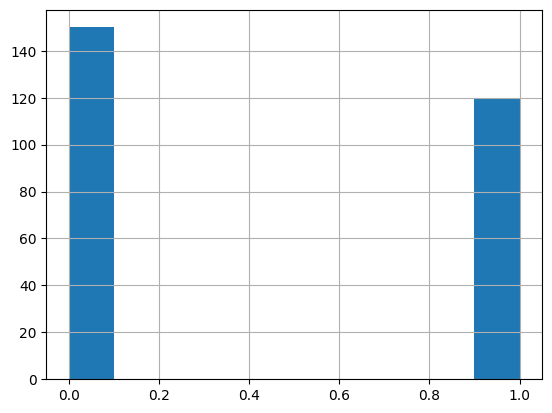

In [208]:
df['target'].hist()

<Axes: >

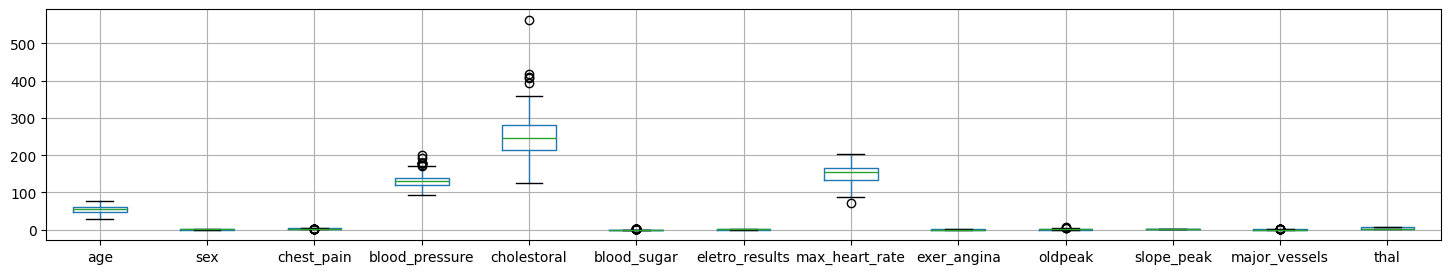

In [12]:
plt.figure(figsize=(18,3))
df[cols].boxplot()

<Axes: >

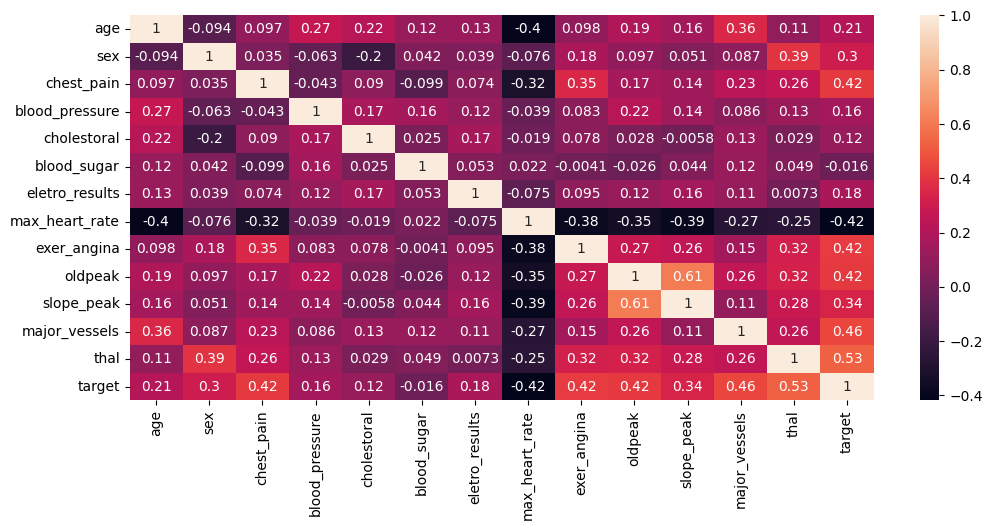

In [13]:
plt.figure(figsize=(12,5))
sns.heatmap(df.corr('pearson'), annot=True)

In [14]:
df.corr('pearson').dtypes

age               float64
sex               float64
chest_pain        float64
blood_pressure    float64
cholestoral       float64
blood_sugar       float64
eletro_results    float64
max_heart_rate    float64
exer_angina       float64
oldpeak           float64
slope_peak        float64
major_vessels     float64
thal              float64
target            float64
dtype: object

correlação regular entre:
- target e [chest_pain, max_heart_rate, exer_angina, oldpeak, major_vessels, thal]
- chest_pain e exer_angina
- max_heart_rate e [age, oldpeak, slope_peak]
- oldpeak e slope_peak

In [15]:
# 1/3 | 1/3 | 1/3
BASE_ASSESSOR_SPLIT = 0.3
BASE_TEST_SIZE = 0.5

temp = df[df.target==1]
train_pos, test_pos = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

temp = df[df.target==0]
train_neg, test_neg = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

Xb_train, Xb_test, yb_train, yb_test = train_test_split(pd.concat([train_pos[cols], train_neg[cols]], ignore_index=True), # X
                                                            pd.concat([train_pos['target'], train_neg['target']], ignore_index=True), # y
                                                            test_size=BASE_TEST_SIZE, shuffle=True, random_state=seed)

In [16]:
scaler = StandardScaler()

Xb_train_norm = scaler.fit_transform(Xb_train, yb_train)
Xb_test_norm = scaler.transform(Xb_test)

# se eu fosse normalizar os dados de teste do assessor, eu usaria o mesmo scaler?

In [17]:
Xa_test = pd.concat([test_pos[cols], test_neg[cols]], ignore_index=True)
ya_test = pd.concat([test_pos['target'], test_neg['target']], ignore_index=True)
Xa_test_norm = scaler.transform(Xa_test)

# Base Models

In [18]:
NUM_TRIALS = 25
performs = {}
models_error = pd.DataFrame()
models = []

In [19]:
def register_performance(train_set:list|tuple, test_set:list|tuple, model, model_name:str, pdict:dict=performs):
    assert (len(train_set)==2) & (len(test_set)==2)

    # train_set
    pred = model.predict(train_set[0])

    #try:
    #    pred_proba = model.predict_proba(train_set[0])[:, 1]
    #    pred_proba = [1-max(prob) for prob in pred_proba]
    #except AttributeError:
    #    pred_proba = model.decision_function(train_set[0])
    #    check = False
    #else:
    #    check = True

    pred_proba = model.predict_proba(train_set[0])
    minprob = [1-max(prob) for prob in pred_proba]

    metrics = compute_performance_metrics(train_set[1], pred, pred_proba[:,1])

    print('[Training]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name] = {'train': {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                   'recall':metrics[1],
                                   'precision':metrics[2], 'f1':metrics[3],
                                   'auroc':metrics[4], 'aupr':metrics[5]}}
    # test_set
    pred = model.predict(test_set[0])

    #if(check):
    pred_proba = model.predict_proba(test_set[0])
    minprob = [1-max(prob) for prob in pred_proba]
    #else:
    #    pred_proba = model.decision_function(test_set[0])

    metrics = compute_performance_metrics(test_set[1], pred, pred_proba[:,1])

    print('\n[Testing]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name]['test'] = {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                 'recall':metrics[1],
                                 'precision':metrics[2], 'f1':metrics[3],
                                 'auroc':metrics[4], 'aupr':metrics[5]}

### Decision Tree

In [20]:
#dtree = DecisionTreeClassifier(random_state=seed)#.fit(Xb_train, yb_train)

dt_params = {'max_depth':[None,10,20,30], 
             'criterion':['gini','entropy','log_loss'],
             'min_samples_split':[2,5,10,20,40,60], 
             'min_samples_leaf':[1,2,10,30]}

g_search = GridSearchCV(DecisionTreeClassifier(random_state=seed), dt_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
dtree = g_search.best_estimator_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 40}


In [21]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), dtree, 'dtree')

[Training]

Accuracy:         0.8404
Recall:           0.9362
Precision:        0.7857
F1:               0.8544
AUROC:            0.9108
AUPR:             0.8889
1-maxProb média:  0.1596
1-maxProb dp:     0.1609

[Testing]

Accuracy:         0.7474
Recall:           0.9459
Precision:        0.6140
F1:               0.7447
AUROC:            0.8318
AUPR:             0.6766
1-maxProb média:  0.1787
1-maxProb dp:     0.1596


In [22]:
models_error['dtree'] = 1 - dtree.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models_error.head()

dtree
0  0.357143
1  0.965517
2  0.357143
3  0.461538
4  0.078947

In [23]:
models.append(dtree)

### Stochastic Gradient Descent
(SGD)

In [24]:
#sgd = SGDClassifier(random_state=seed, loss='log_loss', n_jobs=-1).fit(Xb_train_norm, yb_train)

sgd_params = {
    'loss': ['log_loss', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-4, 1e-3, 1e-2]
}

g_search = GridSearchCV(SGDClassifier(random_state=seed), sgd_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
sgd = g_search.best_estimator_

{'alpha': 0.01, 'loss': 'log_loss', 'penalty': 'l1'}


In [25]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), sgd, 'sgd')
models_error['sgd'] = 1 - sgd.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(sgd)

[Training]

Accuracy:         0.8936
Recall:           0.8511
Precision:        0.9302
F1:               0.8889
AUROC:            0.9670
AUPR:             0.9704
1-maxProb média:  0.1241
1-maxProb dp:     0.1313

[Testing]

Accuracy:         0.8000
Recall:           0.8919
Precision:        0.6875
F1:               0.7765
AUROC:            0.8700
AUPR:             0.7426
1-maxProb média:  0.1531
1-maxProb dp:     0.1398


### Logistic Regression

In [26]:
lr = LogisticRegression(random_state=seed, n_jobs=-1).fit(Xb_train_norm, yb_train)

lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

g_search = GridSearchCV(LogisticRegression(random_state=seed), lr_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
lr = g_search.best_estimator_

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [27]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), lr, 'lr')
models_error['lr'] = 1 - lr.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(lr)

[Training]

Accuracy:         0.8723
Recall:           0.8298
Precision:        0.9070
F1:               0.8667
AUROC:            0.9593
AUPR:             0.9632
1-maxProb média:  0.1991
1-maxProb dp:     0.1231

[Testing]

Accuracy:         0.8000
Recall:           0.7838
Precision:        0.7250
F1:               0.7532
AUROC:            0.8914
AUPR:             0.8023
1-maxProb média:  0.2386
1-maxProb dp:     0.1275


### K-Nearest Neighbors

(KNN)

In [28]:
#knn = KNeighborsClassifier(n_jobs=-1).fit(Xb_train_norm, yb_train)

knn_params = {
    'n_neighbors': list(range(3,21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

g_search = GridSearchCV(KNeighborsClassifier(), knn_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
knn = g_search.best_estimator_

{'metric': 'euclidean', 'n_neighbors': 17, 'weights': 'uniform'}


In [29]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), knn, 'knn')
models_error['knn'] = 1 - knn.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(knn)

[Training]

Accuracy:         0.8617
Recall:           0.7872
Precision:        0.9250
F1:               0.8506
AUROC:            0.9350
AUPR:             0.9311
1-maxProb média:  0.1996
1-maxProb dp:     0.1341

[Testing]

Accuracy:         0.8421
Recall:           0.7838
Precision:        0.8056
F1:               0.7945
AUROC:            0.9091
AUPR:             0.8460
1-maxProb média:  0.2198
1-maxProb dp:     0.1426


### Support Vector Machine - Linear
(SVM)

In [30]:
#svm_linear = SVC(kernel='linear', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_linear_params = {
    'C': [0.1, 1, 10]
}

g_search = GridSearchCV(SVC(kernel='linear', probability=True, random_state=seed), svm_linear_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_linear = g_search.best_estimator_

{'C': 0.1}


In [31]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_linear , 'svm_linear')
models_error['svm_linear'] = 1 - svm_linear.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_linear)

[Training]

Accuracy:         0.8723
Recall:           0.8511
Precision:        0.8889
F1:               0.8696
AUROC:            0.9588
AUPR:             0.9610
1-maxProb média:  0.1726
1-maxProb dp:     0.1209

[Testing]

Accuracy:         0.7474
Recall:           0.7838
Precision:        0.6444
F1:               0.7073
AUROC:            0.8681
AUPR:             0.7761
1-maxProb média:  0.2227
1-maxProb dp:     0.1389


### Support Vector Machine - Polynomial
(SVM)

In [32]:
#svm_poly = SVC(kernel='poly', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_poly_params = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='poly', probability=True, random_state=seed), svm_poly_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_poly = g_search.best_estimator_

{'C': 1, 'degree': 3, 'gamma': 'scale'}


In [33]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_poly, 'svm_poly')
models_error['svm_poly'] = 1 - svm_poly.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_poly)

[Training]

Accuracy:         0.9574
Recall:           0.9362
Precision:        0.9778
F1:               0.9565
AUROC:            0.9923
AUPR:             0.9932
1-maxProb média:  0.1359
1-maxProb dp:     0.1205

[Testing]

Accuracy:         0.7474
Recall:           0.7297
Precision:        0.6585
F1:               0.6923
AUROC:            0.8476
AUPR:             0.6949
1-maxProb média:  0.2237
1-maxProb dp:     0.1472


### Support Vector Machine - RBF
(SVM)

In [34]:
#svm_rbf = SVC(kernel='rbf', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_rbf_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=seed), svm_rbf_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_rbf = g_search.best_estimator_

{'C': 1, 'gamma': 'scale'}


In [35]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_rbf, 'svm_rbf')
models_error['svm_rbf'] = 1 - svm_rbf.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_rbf)

[Training]

Accuracy:         0.9362
Recall:           0.9362
Precision:        0.9362
F1:               0.9362
AUROC:            0.9896
AUPR:             0.9901
1-maxProb média:  0.1207
1-maxProb dp:     0.0916

[Testing]

Accuracy:         0.7895
Recall:           0.8108
Precision:        0.6977
F1:               0.7500
AUROC:            0.9035
AUPR:             0.8677
1-maxProb média:  0.2082
1-maxProb dp:     0.1550


### Multi-Layer Perceptron
(MLP)

In [36]:
#mlp = MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed).fit(Xb_train_norm, yb_train)

mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001]
}

g_search = GridSearchCV(MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed), mlp_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
mlp = g_search.best_estimator_

/home/CIN/pbsl/Downloads/proj-mtr/.auto/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/CIN/pbsl/Downloads/proj-mtr/.auto/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/CIN/pbsl/Downloads/proj-mtr/.auto/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/CIN/pbsl/Downloads/proj-mtr/.auto/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization has

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'solver': 'sgd'}


In [37]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), mlp, 'mlp')
models_error['mlp'] = 1 - mlp.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(mlp)

[Training]

Accuracy:         0.9255
Recall:           0.9149
Precision:        0.9348
F1:               0.9247
AUROC:            0.9846
AUPR:             0.9856
1-maxProb média:  0.1262
1-maxProb dp:     0.1304

[Testing]

Accuracy:         0.8000
Recall:           0.8919
Precision:        0.6875
F1:               0.7765
AUROC:            0.8774
AUPR:             0.7919
1-maxProb média:  0.1676
1-maxProb dp:     0.1431


### Kolmogorov-Arnold Network
(KAN)

In [38]:
kan_cv = int(input('Rodar CV da KAN? (0-Não / 1-Sim): '))

In [39]:
'''dataset = {'train_input': Xb_train_norm,
           'train_label': yb_train,
           'test_input': Xb_test_norm,
           'test_label': yb_test}'''

#best_width = [13,5,5,2]

kan_params = {'width': [[13,2,2,2], [13,3,2], [13,20,2]],
              'grid': [3, 6, 8],
              'lr': [0.0001, 0.001, 0.01],
              'lamb': [0.005, 0.1]}

if(kan_cv):
    best_score = 0
    for w in kan_params['width']:
        for g in kan_params['grid']:
            for lr in kan_params['lr']:
                for l in kan_params['lamb']:
                    score = cross_val_score(KANClassifier(w, grid=g, lr=lr, lamb=l, random_state=seed, grid_eps=1, steps=15), X=Xb_train_norm, y=yb_train, cv=5, error_score=0).mean()
                    if(score > best_score):
                        best_score = score
                        best_width = w
                        best_grid = g
                        best_lr = lr
                        best_lamb = l
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15).fit(Xb_train_norm, yb_train)
    with open('kan_params/heart.json', 'w') as f:
        json.dump({'width': best_width, 'grid': best_grid, 'lr': best_lr, 'lamb': best_lamb}, f)
        #joblib.dump(kanet.state_dict(), 'kan_params/heart.pkl')
    save(kanet.state_dict(), 'kan_params/heart.pt')
else:
    with open('kan_params/heart.json', 'r') as f:
        kan_dict = json.load(f)
    best_width = kan_dict['width']
    best_grid = kan_dict['grid']
    best_lr = kan_dict['lr']
    best_lamb = kan_dict['lamb']
    
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15)
    kanet.load_state_dict(load('kan_params/heart.pt', weights_only=True))

print('width: {},\ngrid: {},\nlr: {},\nlamb: {}'.format(best_width, best_grid, best_lr, best_lamb))

| train_loss: 8.32e-01 | test_loss: 8.32e-01 | reg: 2.32e+00 | : 100%|█| 15/15 [00:03<00:00,  4.62it
| train_loss: 8.30e-01 | test_loss: 8.30e-01 | reg: 2.85e+00 | : 100%|█| 15/15 [00:02<00:00,  6.08it
| train_loss: 8.30e-01 | test_loss: 8.30e-01 | reg: 2.58e+00 | : 100%|█| 15/15 [00:02<00:00,  5.96it
| train_loss: 8.32e-01 | test_loss: 8.32e-01 | reg: 2.38e+00 | : 100%|█| 15/15 [00:02<00:00,  6.19it
| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 3.13e+00 | : 100%|█| 15/15 [00:02<00:00,  6.20it
| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 2.21e+00 | : 100%|█| 15/15 [00:02<00:00,  6.10it
| train_loss: 8.30e-01 | test_loss: 8.30e-01 | reg: 2.47e+00 | : 100%|█| 15/15 [00:02<00:00,  6.23it
| train_loss: 8.35e-01 | test_loss: 8.35e-01 | reg: 2.69e+00 | : 100%|█| 15/15 [00:02<00:00,  6.39it
| train_loss: 8.32e-01 | test_loss: 8.32e-01 | reg: 2.21e+00 | : 100%|█| 15/15 [00:02<00:00,  6.40it
| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 2.18e+00 | : 100%|█| 15/15 [00:02<00:00

width: [[13, 0], [20, 0], [2, 0]],
grid: 6,
lr: 0.01,
lamb: 0.005


In [40]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), kanet, 'kan')
models_error['kan'] = 1 - kanet.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(kanet)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0312
1-maxProb dp:     0.0581

[Testing]

Accuracy:         0.7579
Recall:           0.8378
Precision:        0.6458
F1:               0.7294
AUROC:            0.8031
AUPR:             0.6031
1-maxProb média:  0.0608
1-maxProb dp:     0.1127


### Random Forest

In [41]:
#rforest = RandomForestClassifier(random_state=seed, n_jobs=-1).fit(Xb_train, yb_train)

parameters = {'max_depth':[None,10,20,30], 
              'criterion':['gini','entropy','log_loss'],
              'min_samples_split':[2,5,10,20,40,60], 
              'min_samples_leaf':[1,2,10,30],
              'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(RandomForestClassifier(random_state=seed), parameters, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
rforest = g_search.best_estimator_

{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 20}


In [42]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), rforest, 'rforest')
models_error['rforest'] = 1 - rforest.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(rforest)

[Training]

Accuracy:         0.9362
Recall:           0.8936
Precision:        0.9767
F1:               0.9333
AUROC:            0.9923
AUPR:             0.9929
1-maxProb média:  0.1925
1-maxProb dp:     0.1323

[Testing]

Accuracy:         0.8211
Recall:           0.7838
Precision:        0.7632
F1:               0.7733
AUROC:            0.9017
AUPR:             0.8420
1-maxProb média:  0.2610
1-maxProb dp:     0.1363


### Gradient Boosting

In [43]:
#gb = GradientBoostingClassifier(random_state=seed).fit(Xb_train, yb_train)

gb_params = {'max_depth':[None,10,20,30], 
             'criterion':['friedman_mse', 'squared_error'],
             'min_samples_split':[2,5,10,20,40,60], 
             'learning_rate': [0.01, 0.05, 0.1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(GradientBoostingClassifier(random_state=seed), gb_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
gb = g_search.best_estimator_

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': None, 'min_samples_split': 40, 'n_estimators': 20}


In [44]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), gb, 'gb')
models_error['gb'] = 1 - gb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(gb)

[Training]

Accuracy:         0.9681
Recall:           0.9787
Precision:        0.9583
F1:               0.9684
AUROC:            0.9975
AUPR:             0.9974
1-maxProb média:  0.2018
1-maxProb dp:     0.1140

[Testing]

Accuracy:         0.7684
Recall:           0.8919
Precision:        0.6471
F1:               0.7500
AUROC:            0.8956
AUPR:             0.8451
1-maxProb média:  0.2475
1-maxProb dp:     0.1244


### AdaBoost

In [45]:
#adab = AdaBoostClassifier(random_state=seed).fit(Xb_train, yb_train)

adab_params = {'learning_rate': [0.01, 0.05, 0.1, 1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(AdaBoostClassifier(random_state=seed), adab_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
adab = g_search.best_estimator_

{'learning_rate': 0.1, 'n_estimators': 150}


In [46]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), adab, 'adab')
models_error['adab'] = 1 - adab.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(adab)

[Training]

Accuracy:         0.9149
Recall:           0.9149
Precision:        0.9149
F1:               0.9149
AUROC:            0.9846
AUPR:             0.9856
1-maxProb média:  0.3277
1-maxProb dp:     0.0980

[Testing]

Accuracy:         0.8000
Recall:           0.8378
Precision:        0.7045
F1:               0.7654
AUROC:            0.8935
AUPR:             0.8181
1-maxProb média:  0.3647
1-maxProb dp:     0.0863


### XGBoost

In [47]:
#xgb = XGBClassifier(random_state=seed).fit(Xb_train, yb_train)

xgb_params = {
    'n_estimators': [20,50,100,150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [None,5,10,20,30],
    'gamma': [None, 0.25, 0.5]
}

g_search = GridSearchCV(XGBClassifier(random_state=seed), xgb_params, n_jobs=1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
xgb = g_search.best_estimator_

{'gamma': None, 'learning_rate': 0.05, 'max_depth': None, 'n_estimators': 150}


In [48]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), xgb, 'xgb')
models_error['xgb'] = 1 - xgb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test] #xgb.predict(Xb_test) != yb_test 
models.append(xgb)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0669
1-maxProb dp:     0.0678

[Testing]

Accuracy:         0.8421
Recall:           0.9459
Precision:        0.7292
F1:               0.8235
AUROC:            0.9073
AUPR:             0.8586
1-maxProb média:  0.1401
1-maxProb dp:     0.1385


## Análise de Correlações

In [49]:
groups = {}
model_names = list(performs.keys())

In [ ]:
ya_train = pd.DataFrame(columns=model_names, index=yb_test.index)

for i in range(len(models)):
    
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xb_test)
    else:
        y_pred = models[i].predict_proba(Xb_test_norm)

    ya_train.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), yb_test]

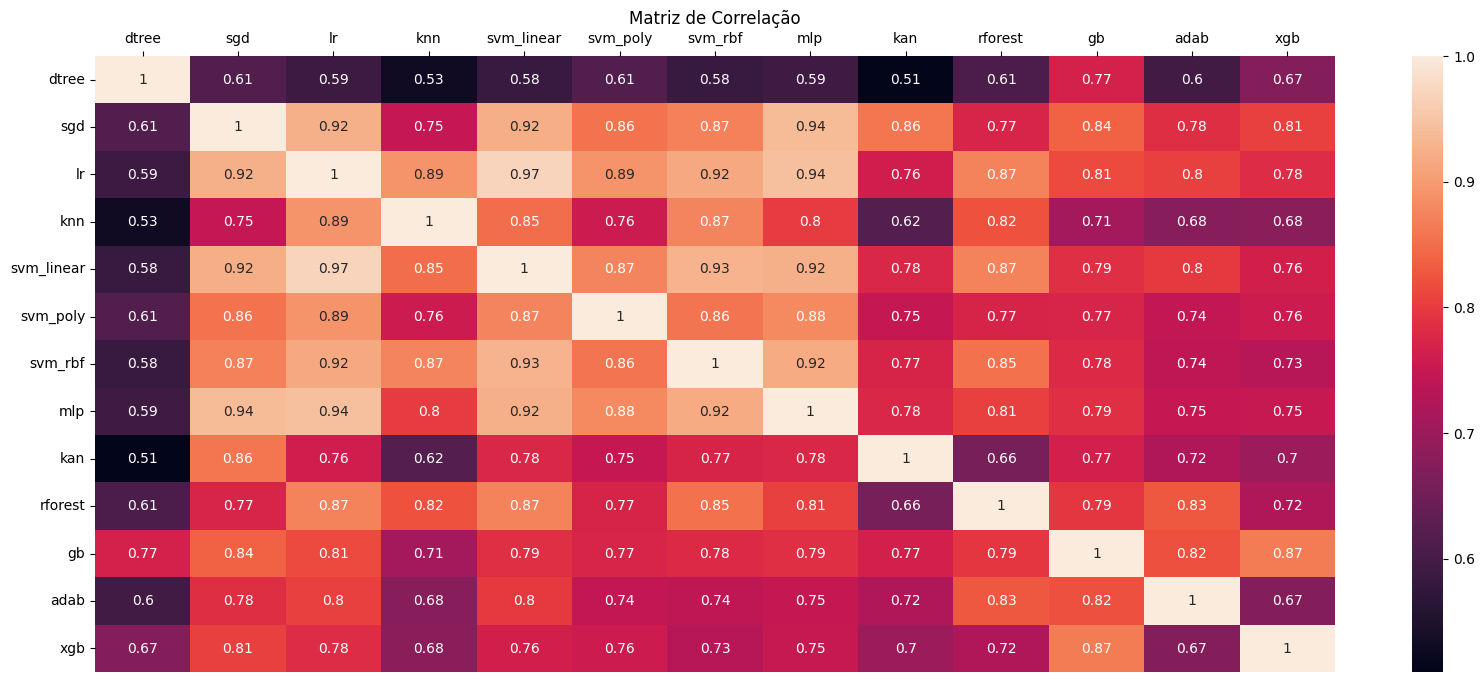

            corr
count  78.000000
mean    0.775272
std     0.105251
min     0.509677
25%     0.725271
50%     0.777679
75%     0.856677
max     0.969531


<Axes: >

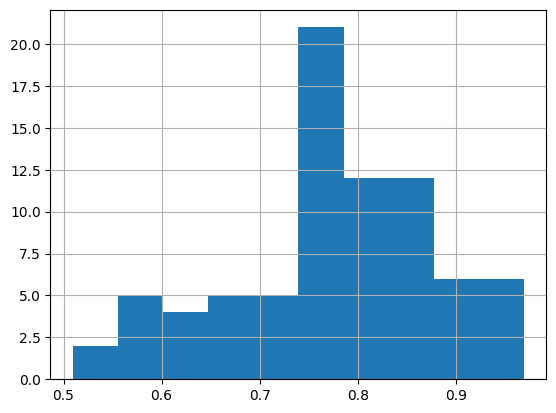

In [160]:
pred_corrls = models_error.corr('pearson')
plt.figure(figsize=(20,8))
plt.title('Matriz de Correlação')
hm = sns.heatmap(pred_corrls, annot=True)
hm.xaxis.tick_top()
plt.show()

corrls_values = pred_corrls.reset_index().melt(id_vars='index', var_name='model2', value_name='corr')
corrls_values = corrls_values.rename(columns={'index': 'model1'})
corrls_values = corrls_values[corrls_values['model1']!=corrls_values['model2']].reset_index(drop=True)
# ordenando strings por linha
corrls_values.loc[:,['model1','model2']] = pd.DataFrame(np.sort(corrls_values.loc[:,['model1','model2']].values, axis=1), columns=['model1','model2']) 
corrls_values = corrls_values.drop_duplicates().reset_index(drop=True)

print(corrls_values[['corr']].describe())

corrls_values['corr'].hist()

Se for pegar um grupo para analisar, tentar usar como a correlação mínima entre previsões o 3º quantil, o que daria por volta de  (no caso atual)

In [55]:
def group_search_help(df: pd.DataFrame, min_score: int, models: list | set = None, base_group: list = []):
    if models is None:
        models = ['dtree', 'sgd', 'lr', 'knn', 'svm_linear', 'svm_poly', 'svm_rbf', 'mlp',
                  'kan', 'rforest', 'gb', 'adab', 'xgb']

    if len(base_group) == 0:
        base_group, models = models[:1], models[1:]

    output_groups = []

    for m in models:
        check = True
        for bg in base_group:
            corr = df.at[bg, m]
            if np.isnan(corr) or corr < min_score:
                check = False
                break
        if check:
            temp = models.copy()
            temp.remove(m)
            output_groups.append(
                group_search_help(df, min_score, temp, base_group + [m])
            )

    if len(output_groups) == 0:
        return base_group

    return output_groups

def group_search(df: pd.DataFrame, min_score: int, models: list = None):
    if models is None:
        models = ['dtree', 'sgd', 'lr', 'knn', 'svm_linear', 'svm_poly', 'svm_rbf', 'mlp',
                  'kan', 'rforest', 'gb', 'adab', 'xgb']

    # Corrige valores abaixo do min_score
    df = df.map(lambda x: np.nan if x < min_score else x)

    raw_groups = []
    for i in range(len(models)):
        raw_groups.append(group_search_help(df, min_score, models[i:]))

    return remove_subgroups(flatten_groups(raw_groups))
    
def flatten_groups(nested_list):
    flat_list = []

    def _flatten(item):
        if isinstance(item[0], list):
            for subitem in item:
                _flatten(subitem)
        else:
            flat_list.append(sorted(item))  # ordena para facilitar comparação de subconjuntos

    _flatten(nested_list)
    return flat_list

def remove_subgroups(groups:list):
    # Remove duplicatas (grupos com os mesmos elementos, em qualquer ordem)
    seen = set()
    unique_groups = []
    for g in groups:
        frozen = frozenset(g)
        if frozen not in seen:
            seen.add(frozen)
            unique_groups.append(g)

    # Agora removemos subconjuntos estritos
    filtered_groups = []
    for g in unique_groups:
        is_subset = False
        for other in unique_groups:
            if g != other and set(g).issubset(set(other)):
                is_subset = True
                break
        if not is_subset:
            filtered_groups.append(g)

    return filtered_groups

In [161]:
min_score = corrls_values['corr'].quantile(0.75)

print('Min_score:', min_score)

groups['true_assessor_train'] = group_search(pred_corrls, min_score)
groups['true_assessor_train']

Min_score: 0.8566772593521603


[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear', 'svm_rbf'],
 ['kan', 'sgd'],
 ['knn', 'lr', 'svm_rbf'],
 ['lr', 'mlp', 'svm_linear', 'svm_poly', 'svm_rbf'],
 ['lr', 'rforest', 'svm_linear'],
 ['gb', 'xgb'],
 ['adab']]

fazer com que todos os modelos do grupo tenham uma correlação acima do score mínimo entre todos eles? Ou fazer com que o próximo modelo encontrado do grupo tenha uma correlação acima do mínimo com o modelo mais recente?

(provavelmente o primeiro)

# Assessors

In [ ]:
def nmse(y_true, y_pred, sample_weight=None, 
         multioutput="uniform_average"):
    mse_error = mse(y_true, y_pred, sample_weight=sample_weight, multioutput="raw_values")
    variance = np.var(np.asarray(y_true), axis=0)
    
    if 0 in variance.flatten():
        raise ValueError("A variância dos valores reais é zero; não é possível normalizar.")
    
    output_errors = mse_error / variance
    if isinstance(multioutput, str):
        if multioutput == "raw_values":
            return output_errors
        elif multioutput == "uniform_average":
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)

def nmse_models(y_true, y_pred):
    y_pred = pd.DataFrame(y_pred, columns=y_true.columns)    
    error = {}
    for c in y_true.columns:
        error[c] = nmse(y_true[c], y_pred[c])
    return error

def mse_models(y_true, y_pred):
    y_pred = pd.DataFrame(y_pred, columns=y_true.columns)
    error = {}
    for c in y_true.columns:
        error[c] = ((y_true[c] - y_pred[c])**2).mean()
    return error

def rmse_models(y_true, y_pred):
    y_pred = pd.DataFrame(y_pred, columns=y_true.columns)
    error = {}
    for c in y_true.columns:
        error[c] = (((y_true[c] - y_pred[c])**2).mean())**0.5
    return error

def mae_models(y_true, y_pred):
    y_pred = pd.DataFrame(y_pred, columns=y_true.columns)
    error = {}
    for c in y_true.columns:
        error[c] = (abs(y_true[c] - y_pred[c])).mean()
    return error

In [59]:
models_error

dtree       sgd        lr       knn  svm_linear  svm_poly   svm_rbf  \
0   0.357143  0.240465  0.416048  0.470588    0.434321  0.412274  0.464318   
1   0.965517  0.646876  0.452941  0.294118    0.563983  0.699817  0.540896   
2   0.357143  0.733488  0.680125  0.705882    0.781501  0.454220  0.602347   
3   0.461538  0.050179  0.282246  0.411765    0.283095  0.363057  0.428255   
4   0.078947  0.607804  0.476185  0.352941    0.456514  0.520778  0.484935   
..       ...       ...       ...       ...         ...       ...       ...   
90  0.642857  0.251887  0.240224  0.117647    0.158953  0.239872  0.130492   
91  0.078947  0.333324  0.347808  0.176471    0.307960  0.362896  0.099141   
92  0.078947  0.005488  0.034124  0.000000    0.026629  0.008222  0.028253   
93  0.357143  0.079571  0.237134  0.117647    0.353068  0.508529  0.282989   
94  0.034483  0.005135  0.090587  0.176471    0.070003  0.177738  0.039979   

         mlp       kan   rforest        gb      adab       xgb  
0   0.306677  0.445854  0.347436  0.327406  0.391579  0.491934  
1   0.632825  0.939500  0.401496  0.724044  0.409544  0.846597  
2   0.485079  0.990630  0.652796  0.568036  0.514672  0.480499  
3   0.226214  0.006482  0.297672  0.193701  0.322106  0.085934  
4   0.622468  0.998023  0.287918  0.496492  0.436597  0.461939  
..       ...       ...       ...       ...       ...       ...  
90  0.062666  0.275233  0.412678  0.528561  0.438628  0.577306  
91  0.254011  0.013751  0.322082  0.286018  0.448629  0.358701  
92  0.002553  0.000910  0.098333  0.082949  0.234413  0.009170  
93  0.156984  0.192204  0.452198  0.260969  0.476012  0.057820  
94  0.040834  0.000026  0.178822  0.102502  0.274080  0.012902  

[95 rows x 13 columns]

In [60]:
model_names = list(performs.keys())

Xa_train = Xb_test.copy()
ya_train_tgt = yb_test
ya_train = models_error.copy()

ya_train.head()

dtree       sgd        lr       knn  svm_linear  svm_poly   svm_rbf  \
0  0.357143  0.240465  0.416048  0.470588    0.434321  0.412274  0.464318   
1  0.965517  0.646876  0.452941  0.294118    0.563983  0.699817  0.540896   
2  0.357143  0.733488  0.680125  0.705882    0.781501  0.454220  0.602347   
3  0.461538  0.050179  0.282246  0.411765    0.283095  0.363057  0.428255   
4  0.078947  0.607804  0.476185  0.352941    0.456514  0.520778  0.484935   

        mlp       kan   rforest        gb      adab       xgb  
0  0.306677  0.445854  0.347436  0.327406  0.391579  0.491934  
1  0.632825  0.939500  0.401496  0.724044  0.409544  0.846597  
2  0.485079  0.990630  0.652796  0.568036  0.514672  0.480499  
3  0.226214  0.006482  0.297672  0.193701  0.322106  0.085934  
4  0.622468  0.998023  0.287918  0.496492  0.436597  0.461939

In [61]:
Xa_train.head()

age  sex  chest_pain  blood_pressure  cholestoral  blood_sugar  \
76   59.0  1.0         3.0           126.0        218.0          1.0   
108  52.0  1.0         1.0           152.0        298.0          1.0   
16   65.0  1.0         1.0           138.0        282.0          1.0   
60   67.0  1.0         4.0           125.0        254.0          1.0   
187  65.0  0.0         3.0           160.0        360.0          0.0   

     eletro_results  max_heart_rate  exer_angina  oldpeak  slope_peak  \
76              0.0           134.0          0.0      2.2         2.0   
108             0.0           178.0          0.0      1.2         2.0   
16              2.0           174.0          0.0      1.4         2.0   
60              0.0           163.0          0.0      0.2         2.0   
187             2.0           151.0          0.0      0.8         1.0   

     major_vessels  thal  
76             1.0   6.0  
108            0.0   7.0  
16             1.0   3.0  
60             2.0   7.0  
187            0.0   3.0

In [62]:
ya_test = pd.DataFrame(ya_test)

for i in range(len(models)):
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xa_test)
    else:
        y_pred = models[i].predict_proba(Xa_test_norm)
        
    ya_test.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), ya_test['target']]

ya_test_tgt = ya_test['target']
ya_test = ya_test.drop(columns=['target'])
ya_test.head()

dtree       sgd        lr       knn  svm_linear  svm_poly   svm_rbf  \
0  0.034483  0.113134  0.205486  0.176471    0.147096  0.283670  0.074810   
1  0.034483  0.076642  0.172552  0.176471    0.186982  0.183808  0.101105   
2  0.921053  0.799683  0.663781  0.764706    0.714991  0.651247  0.874132   
3  0.921053  0.730773  0.514733  0.529412    0.500000  0.547081  0.493951   
4  0.461538  0.382534  0.572602  0.705882    0.445445  0.395322  0.513044   

        mlp       kan   rforest        gb      adab       xgb  
0  0.070668  0.000203  0.160674  0.151149  0.351828  0.028248  
1  0.082249  0.013622  0.226245  0.138091  0.245138  0.028824  
2  0.740503  0.984894  0.731392  0.794905  0.611459  0.924587  
3  0.571163  0.999502  0.652502  0.752282  0.595652  0.899618  
4  0.476932  0.874196  0.733779  0.602173  0.634329  0.751114

#### Análise de correlações

Conjunto de Treinamento:

O conjunto de teste dos modelos base já é o conjunto de treinamento dos assessores.

Conjunto de Teste:

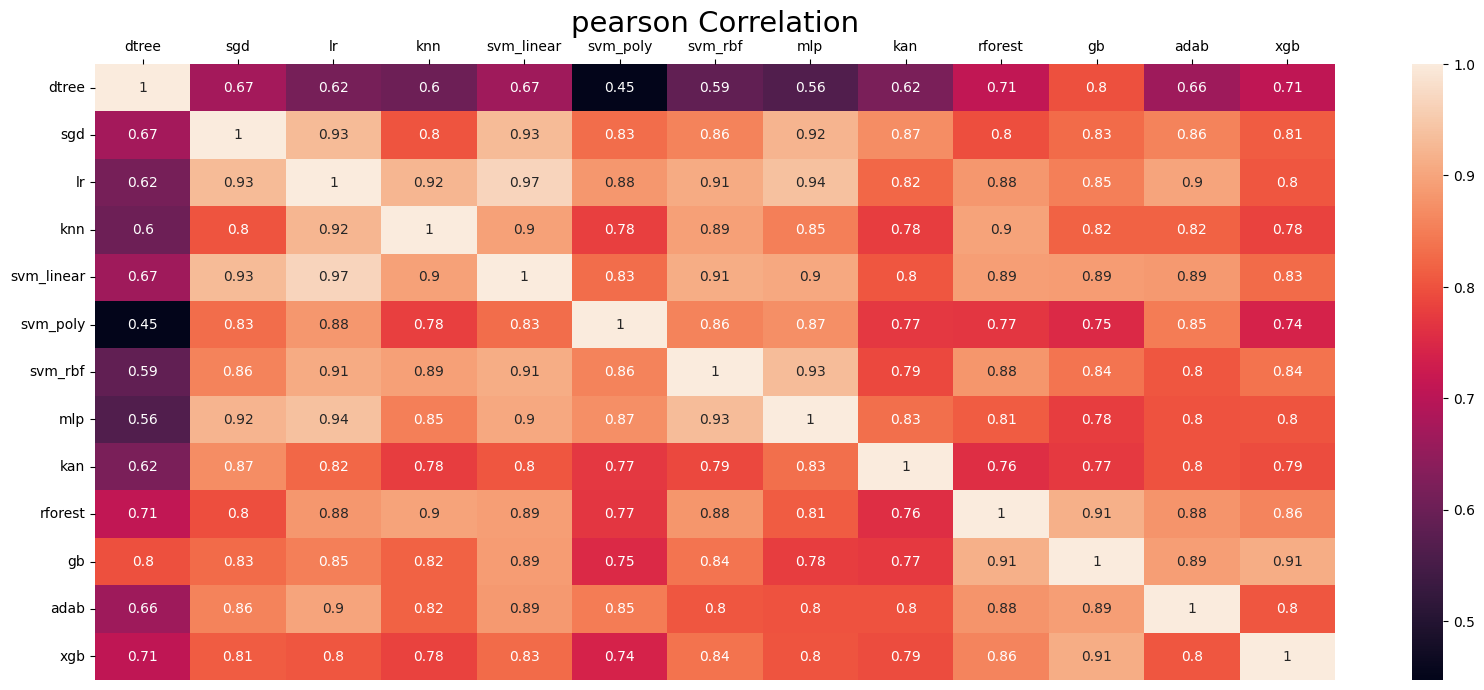

            corr
count  78.000000
mean    0.814193
std     0.096705
min     0.447267
25%     0.779201
50%     0.828885
75%     0.884600
max     0.967602


<Axes: >

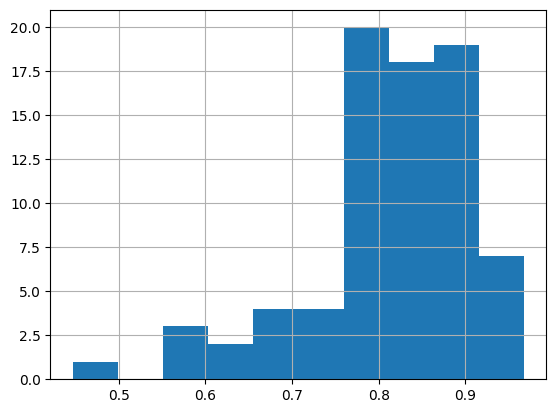

In [137]:
pred_corrls2 = ya_test.corr('pearson')
plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(pred_corrls2, annot=True)
hm.xaxis.tick_top()
plt.show()

corrls_values2 = pred_corrls2.reset_index().melt(id_vars='index', var_name='model2', value_name='corr')
corrls_values2 = corrls_values2.rename(columns={'index': 'model1'})
corrls_values2 = corrls_values2[corrls_values2['model1']!=corrls_values2['model2']].reset_index(drop=True)
# ordenando strings por linha
corrls_values2.loc[:,['model1','model2']] = pd.DataFrame(np.sort(corrls_values2.loc[:,['model1','model2']].values, axis=1), columns=['model1','model2']) 
corrls_values2 = corrls_values2.drop_duplicates().reset_index(drop=True)

print(corrls_values2[['corr']].describe())

corrls_values2['corr'].hist()

In [139]:
min_score2 = corrls_values2['corr'].quantile(0.75)

print('Min_score:', min_score2)

groups['true_assessor_test'] = group_search(pred_corrls2, min_score2)
groups['true_assessor_test']

Min_score: 0.8846000071281495


[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear'],
 ['knn', 'lr', 'svm_linear', 'svm_rbf'],
 ['lr', 'mlp', 'svm_linear', 'svm_rbf'],
 ['adab', 'lr', 'svm_linear'],
 ['knn', 'rforest', 'svm_linear'],
 ['gb', 'rforest', 'svm_linear'],
 ['adab', 'gb', 'svm_linear'],
 ['svm_poly'],
 ['kan'],
 ['gb', 'xgb']]

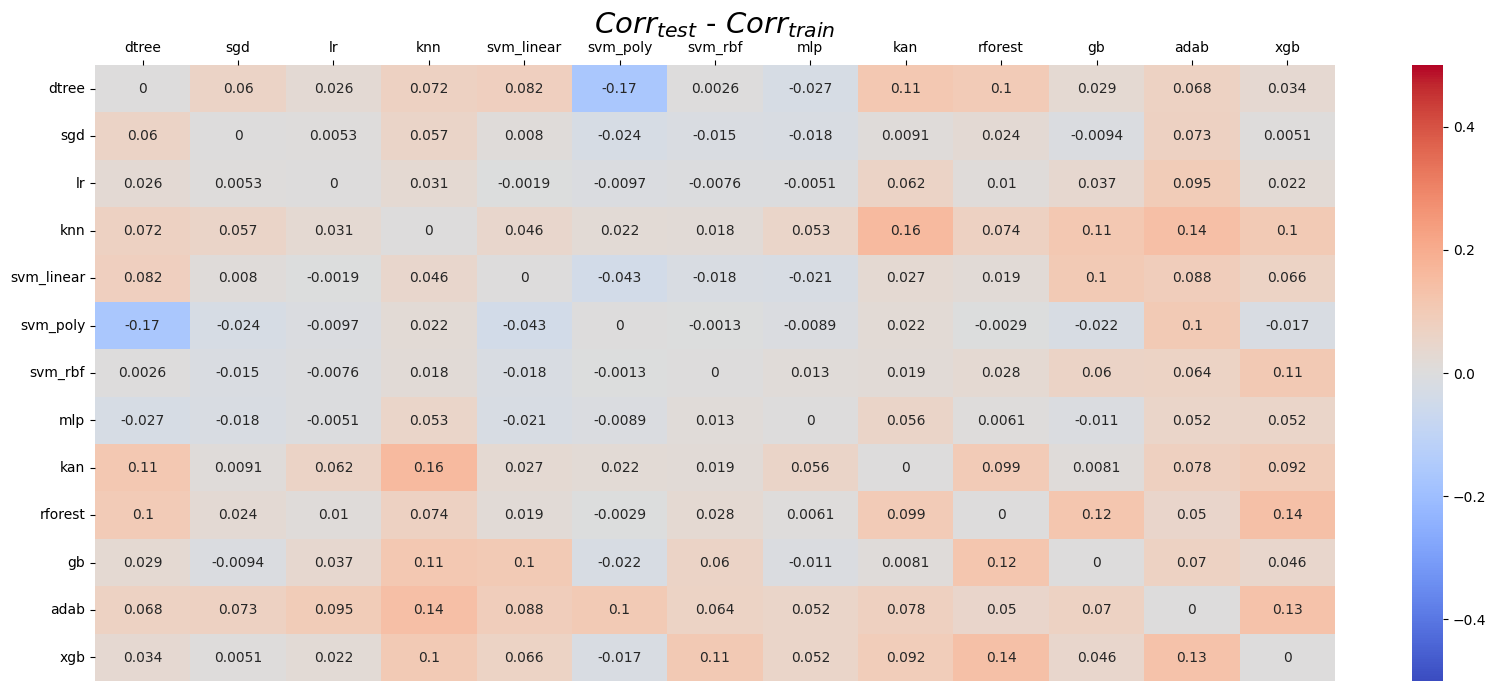

In [141]:
pred_corrls2 = ya_test.corr('pearson')
diff_corrls = pred_corrls2-pred_corrls

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{test}$ - $Corr_{train}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()

## Globais

### Regressor Chain
(RC)

In [69]:
regchain = RegressorChain(RandomForestRegressor(random_state=seed), verbose=True, random_state=seed, cv=5).fit(Xa_train, ya_train)

[Chain] .................. (1 of 13) Processing order 0, total=   0.1s
[Chain] .................. (2 of 13) Processing order 1, total=   0.1s
[Chain] .................. (3 of 13) Processing order 2, total=   0.1s
[Chain] .................. (4 of 13) Processing order 3, total=   0.1s
[Chain] .................. (5 of 13) Processing order 4, total=   0.1s
[Chain] .................. (6 of 13) Processing order 5, total=   0.1s
[Chain] .................. (7 of 13) Processing order 6, total=   0.1s
[Chain] .................. (8 of 13) Processing order 7, total=   0.1s
[Chain] .................. (9 of 13) Processing order 8, total=   0.1s
[Chain] ................. (10 of 13) Processing order 9, total=   0.1s
[Chain] ................ (11 of 13) Processing order 10, total=   0.1s
[Chain] ................ (12 of 13) Processing order 11, total=   0.1s
[Chain] ................ (13 of 13) Processing order 12, total=   0.1s


In [70]:
mse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
rmse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
nmse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
mae_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)

In [142]:
ya_pred = regchain.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}
NMSE: {nmse(ya_test, ya_pred):.4f}''')

mse_df.loc['regchain',:] = mse_models(ya_test, ya_pred)
rmse_df.loc['regchain',:] = rmse_models(ya_test, ya_pred)
nmse_df.loc['regchain',:] = nmse_models(ya_test, ya_pred)
mae_df.loc['regchain',:] = mae_models(ya_test, ya_pred)
mse_df

MSE: 0.0678
RMSE: 0.2525
MAE: 0.1967
NMSE: 1.0224


dtree       sgd        lr       knn  svm_linear  \
regchain             0.091869  0.094910  0.044858  0.049381    0.050228   
multi-output         0.091869  0.101868  0.046417  0.049038    0.052273   
individual           0.093350  0.100006  0.047054  0.047498    0.051631   
regchain(group)      0.091869  0.089725  0.045282  0.049038    0.049828   
multi-output(group)  0.091869  0.101868  0.046417  0.049038    0.052273   

                     svm_poly   svm_rbf       mlp       kan   rforest  \
regchain             0.044900  0.054480  0.077139  0.155929  0.040937   
multi-output         0.048239  0.057327  0.077955  0.175583  0.044409   
individual           0.048239  0.057839  0.075726  0.156486  0.042937   
regchain(group)      0.050739  0.052210  0.075249  0.175583  0.044409   
multi-output(group)  0.048239  0.057327  0.077955  0.175583  0.044409   

                           gb      adab       xgb  
regchain             0.052039  0.019820  0.105312  
multi-output         0.053460  0.020026  0.101638  
individual           0.051187  0.017546  0.086256  
regchain(group)      0.053460  0.020026  0.101638  
multi-output(group)  0.053460  0.020026  0.101638

#### Análise das correlações

Melhorar esse cálculo de correlação para fazer melhor uso do 1-(probabilidade da classe correta)

Conjunto de Treinamento:

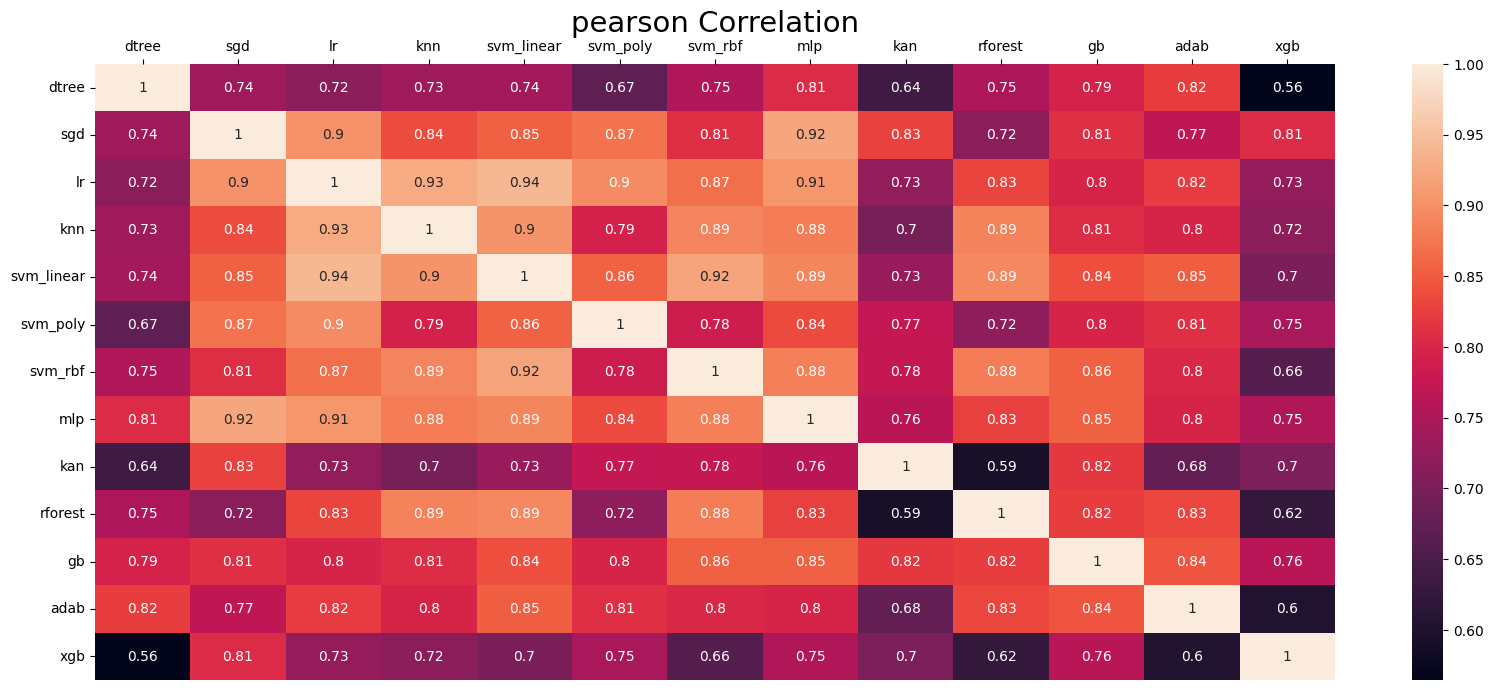

            corr
count  78.000000
mean    0.794399
std     0.083671
min     0.564579
25%     0.737167
50%     0.805403
75%     0.853754
max     0.941994


<Axes: >

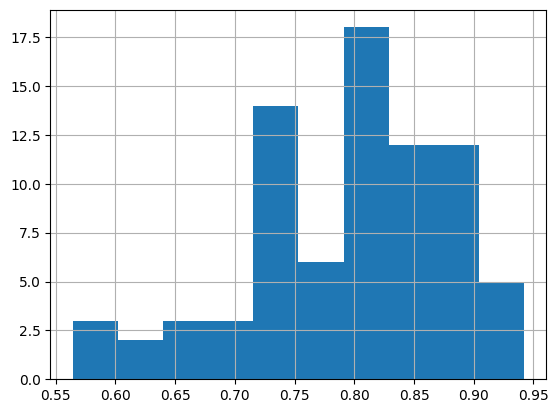

In [143]:
regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
                               index=Xa_train.index,
                               columns=model_names).corr('pearson') 

plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()
plt.show()

regchain_corrls_values = regchain_corrls.reset_index().melt(id_vars='index', var_name='model2', value_name='corr')
regchain_corrls_values = regchain_corrls_values.rename(columns={'index': 'model1'})
regchain_corrls_values = regchain_corrls_values[regchain_corrls_values['model1']!=regchain_corrls_values['model2']].reset_index(drop=True)
# ordenando strings por linha
regchain_corrls_values.loc[:,['model1','model2']] = pd.DataFrame(np.sort(regchain_corrls_values.loc[:,['model1','model2']].values, axis=1), columns=['model1','model2']) 
regchain_corrls_values = regchain_corrls_values.drop_duplicates().reset_index(drop=True)

print(regchain_corrls_values[['corr']].describe())

regchain_corrls_values['corr'].hist()

In [144]:
min_score3 = regchain_corrls_values['corr'].quantile(0.75)

print('Min_score:', min_score3)

groups['regchain_assessor_train'] = group_search(regchain_corrls, min_score3)
groups['regchain_assessor_train']

Min_score: 0.8537539117224131


[['dtree'],
 ['lr', 'sgd', 'svm_linear', 'svm_poly'],
 ['lr', 'mlp', 'sgd', 'svm_linear'],
 ['knn', 'lr', 'mlp', 'svm_linear', 'svm_rbf'],
 ['knn', 'rforest', 'svm_linear', 'svm_rbf'],
 ['gb', 'svm_rbf'],
 ['kan'],
 ['adab'],
 ['xgb']]

Conjunto de Teste:

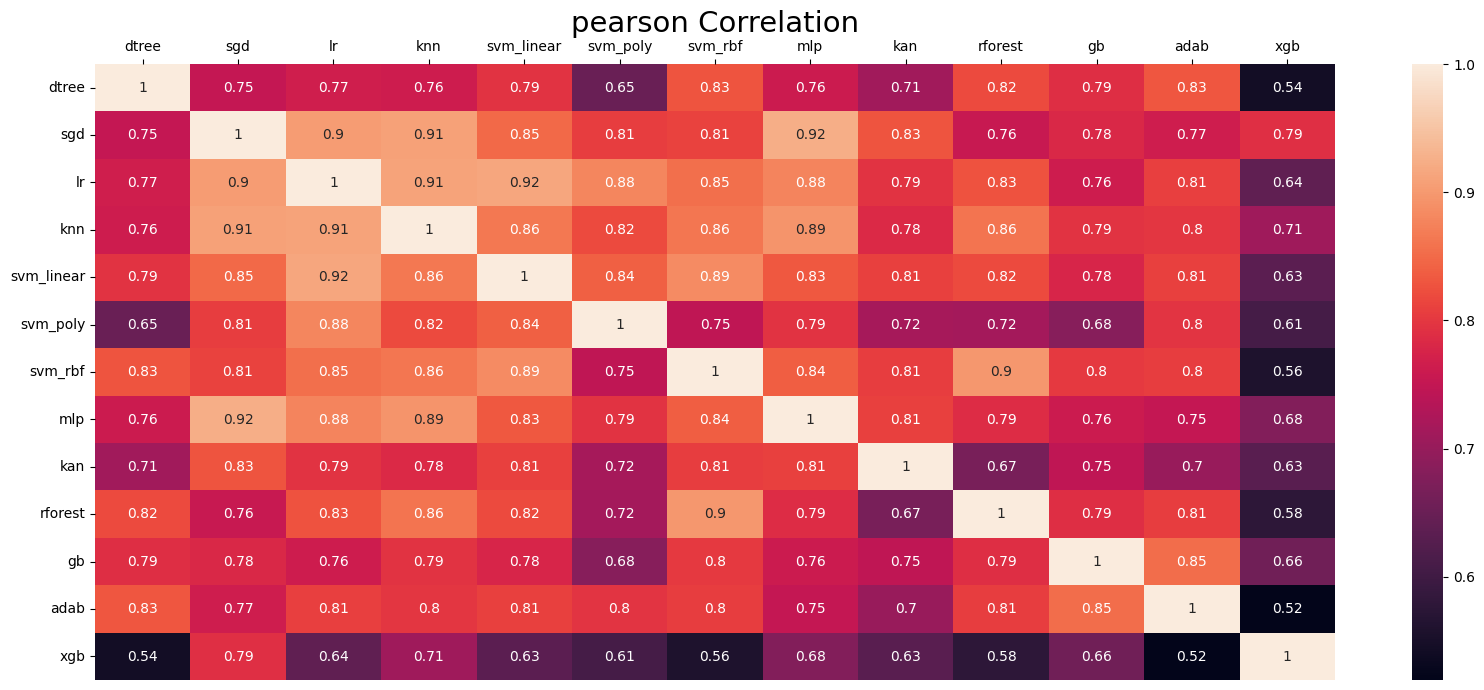

            corr
count  78.000000
mean    0.777951
std     0.089502
min     0.519477
25%     0.746954
50%     0.794701
75%     0.829163
max     0.924065


<Axes: >

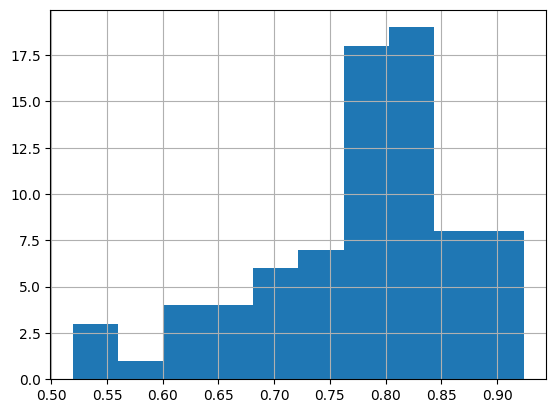

In [145]:
regchain_corrls = pd.DataFrame(regchain.predict(Xa_test), 
                               columns=model_names, 
                               index=Xa_test.index).corr('pearson')

plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()
plt.show()

regchain_corrls_values = regchain_corrls.reset_index().melt(id_vars='index', var_name='model2', value_name='corr')
regchain_corrls_values = regchain_corrls_values.rename(columns={'index': 'model1'})
regchain_corrls_values = regchain_corrls_values[regchain_corrls_values['model1']!=regchain_corrls_values['model2']].reset_index(drop=True)
# ordenando strings por linha
regchain_corrls_values.loc[:,['model1','model2']] = pd.DataFrame(np.sort(regchain_corrls_values.loc[:,['model1','model2']].values, axis=1), columns=['model1','model2']) 
regchain_corrls_values = regchain_corrls_values.drop_duplicates().reset_index(drop=True)

print(regchain_corrls_values[['corr']].describe())

regchain_corrls_values['corr'].hist()

In [146]:
min_score3 = regchain_corrls_values['corr'].quantile(0.75)

print('Min_score:', min_score3)

groups['regchain_assessor_test'] = group_search(regchain_corrls, min_score3)
groups['regchain_assessor_test']

Min_score: 0.829162888269976


[['adab', 'dtree'],
 ['knn', 'lr', 'mlp', 'sgd', 'svm_linear'],
 ['knn', 'lr', 'mlp', 'svm_linear', 'svm_rbf'],
 ['lr', 'svm_linear', 'svm_poly'],
 ['knn', 'rforest', 'svm_rbf'],
 ['kan'],
 ['adab', 'gb'],
 ['xgb']]

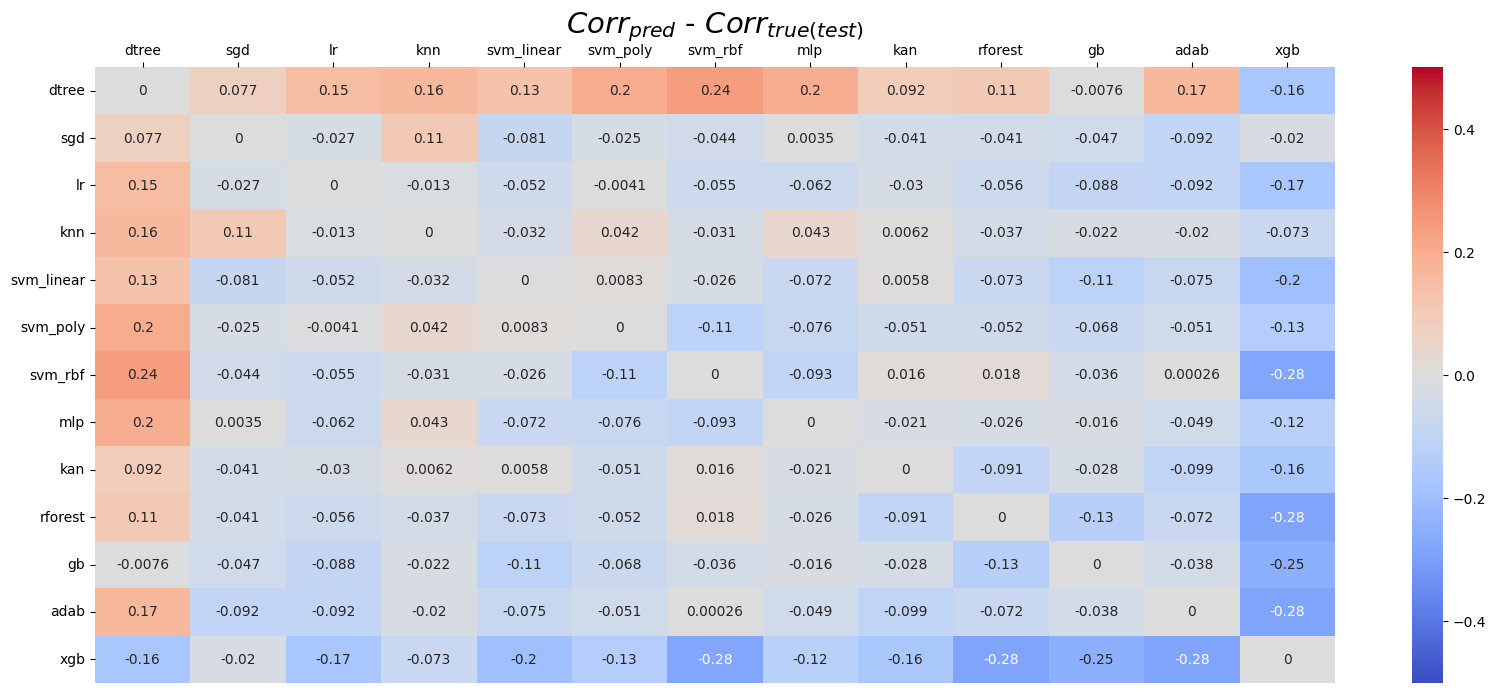

In [147]:
pred_corrls2 = ya_test.corr('pearson')
diff_corrls = regchain_corrls - pred_corrls2

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()

### Multi-Output Regressor 
(ST)

In [81]:
mor = MultiOutputRegressor(RandomForestRegressor(random_state=seed), n_jobs=-1).fit(Xa_train, ya_train)

In [148]:
ya_pred = mor.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}
NMSE: {nmse(ya_test, ya_pred):.4f}''')

#mse_models(ya_test, ya_pred)
mse_df.loc['multi-output',:] = mse_models(ya_test, ya_pred)
rmse_df.loc['multi-output',:] = rmse_models(ya_test, ya_pred)
nmse_df.loc['multi-output',:] = nmse_models(ya_test, ya_pred)
mae_df.loc['multi-output',:] = mae_models(ya_test, ya_pred)
mse_df

MSE: 0.0708
RMSE: 0.2575
MAE: 0.1995
NMSE: 1.0609


dtree       sgd        lr       knn  svm_linear  \
regchain             0.091869  0.094910  0.044858  0.049381    0.050228   
multi-output         0.091869  0.101868  0.046417  0.049038    0.052273   
individual           0.093350  0.100006  0.047054  0.047498    0.051631   
regchain(group)      0.091869  0.089725  0.045282  0.049038    0.049828   
multi-output(group)  0.091869  0.101868  0.046417  0.049038    0.052273   

                     svm_poly   svm_rbf       mlp       kan   rforest  \
regchain             0.044900  0.054480  0.077139  0.155929  0.040937   
multi-output         0.048239  0.057327  0.077955  0.175583  0.044409   
individual           0.048239  0.057839  0.075726  0.156486  0.042937   
regchain(group)      0.050739  0.052210  0.075249  0.175583  0.044409   
multi-output(group)  0.048239  0.057327  0.077955  0.175583  0.044409   

                           gb      adab       xgb  
regchain             0.052039  0.019820  0.105312  
multi-output         0.053460  0.020026  0.101638  
individual           0.051187  0.017546  0.086256  
regchain(group)      0.053460  0.020026  0.101638  
multi-output(group)  0.053460  0.020026  0.101638

#### Análise das correlações

Conjunto de Treinamento:

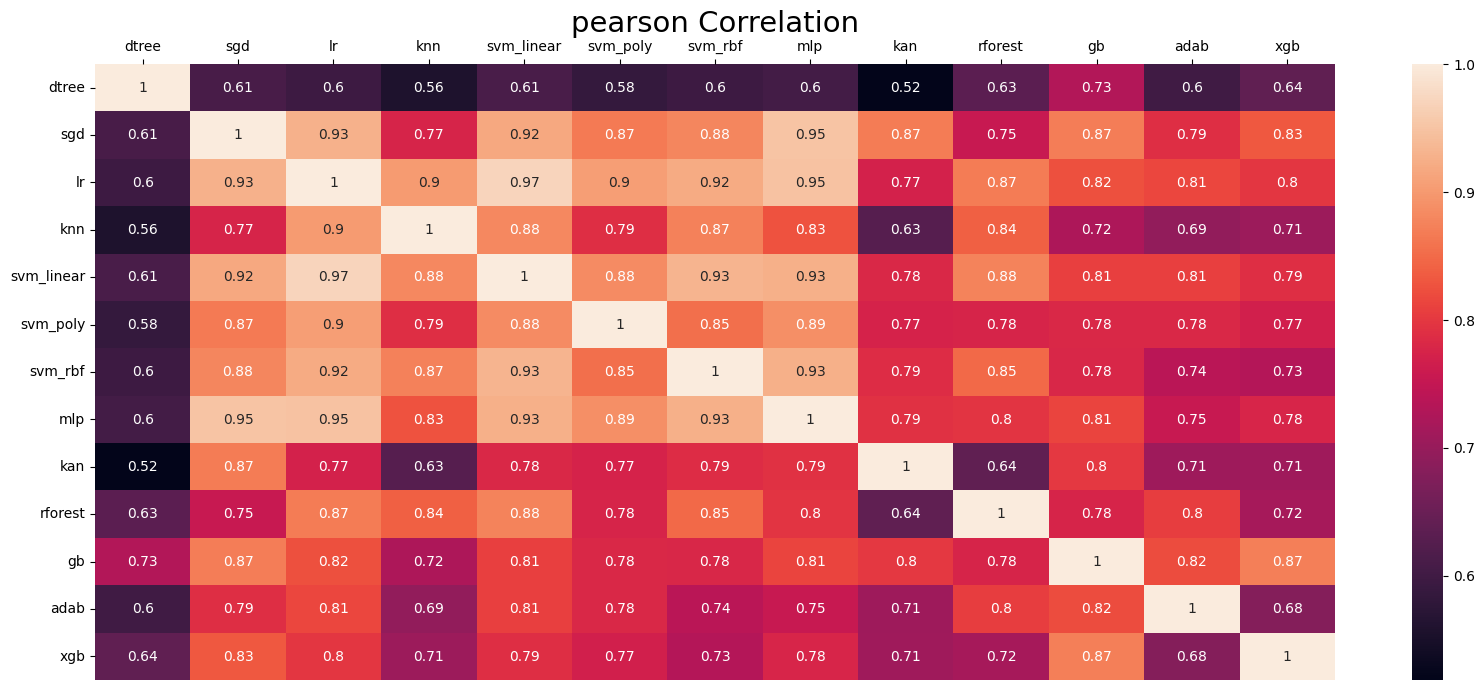

            corr
count  78.000000
mean    0.782913
std     0.105341
min     0.518451
25%     0.725195
50%     0.788303
75%     0.867970
max     0.971393


<Axes: >

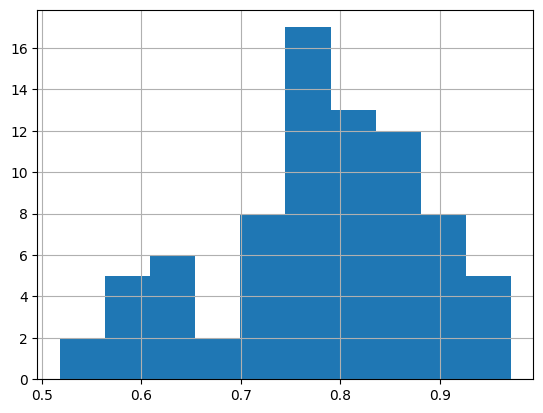

In [149]:
mor_corrls = pd.DataFrame(mor.predict(Xa_train), 
                          columns=model_names, 
                          index=Xa_train.index).corr('pearson')

plt.figure(figsize=(20,8))
plt.title(r'pearson Correlation', fontsize=21)
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()
plt.show()

mor_corrls_values = mor_corrls.reset_index().melt(id_vars='index', var_name='model2', value_name='corr')
mor_corrls_values = mor_corrls_values.rename(columns={'index': 'model1'})
mor_corrls_values = mor_corrls_values[mor_corrls_values['model1']!=mor_corrls_values['model2']].reset_index(drop=True)
# ordenando strings por linha
mor_corrls_values.loc[:,['model1','model2']] = pd.DataFrame(np.sort(mor_corrls_values.loc[:,['model1','model2']].values, axis=1), columns=['model1','model2']) 
mor_corrls_values = mor_corrls_values.drop_duplicates().reset_index(drop=True)

print(mor_corrls_values[['corr']].describe())

mor_corrls_values['corr'].hist()

In [150]:
min_score4 = mor_corrls_values['corr'].quantile(0.75)

print('Min_score:', min_score4)

groups['mor_assessor_train'] = group_search(mor_corrls, min_score4)
groups['mor_assessor_train']

Min_score: 0.8679698711706174


[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear', 'svm_rbf'],
 ['kan', 'sgd'],
 ['gb', 'sgd'],
 ['knn', 'lr', 'svm_linear', 'svm_rbf'],
 ['lr', 'mlp', 'svm_linear', 'svm_poly'],
 ['rforest', 'svm_linear'],
 ['gb', 'xgb'],
 ['adab']]

Conjunto de Teste:

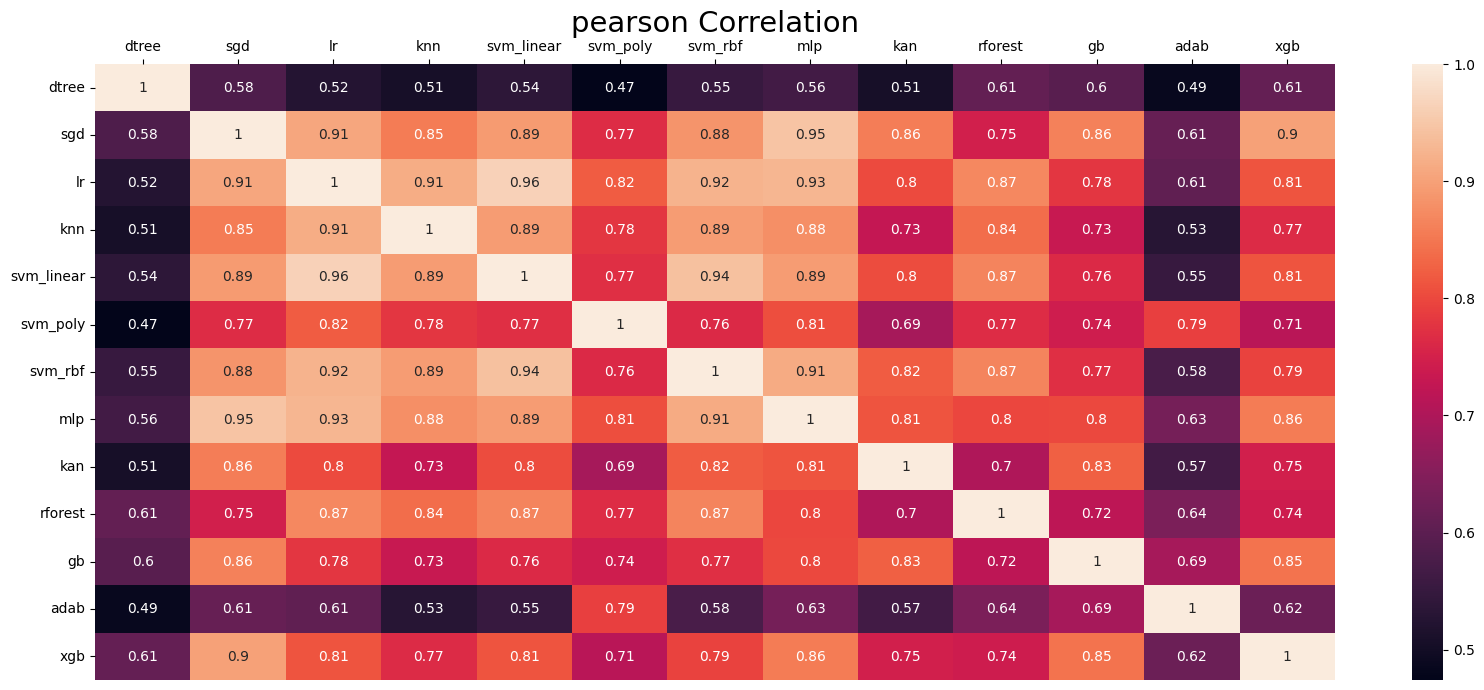

            corr
count  78.000000
mean    0.751662
std     0.131248
min     0.474139
25%     0.633677
50%     0.774686
75%     0.856471
max     0.963515


<Axes: >

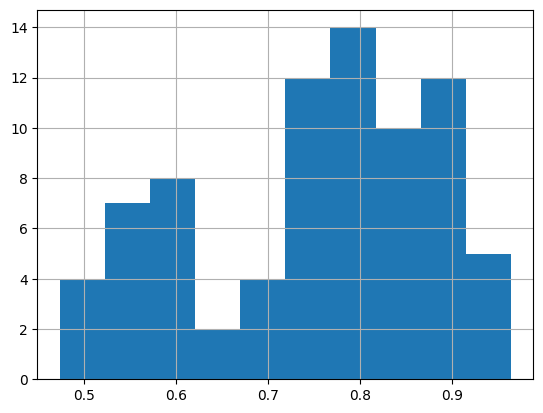

In [151]:
mor_corrls = pd.DataFrame(ya_pred, 
                          columns=model_names, 
                          index=Xa_test.index, dtype=float).corr('pearson')

plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()
plt.show()

mor_corrls_values = mor_corrls.reset_index().melt(id_vars='index', var_name='model2', value_name='corr')
mor_corrls_values = mor_corrls_values.rename(columns={'index': 'model1'})
mor_corrls_values = mor_corrls_values[mor_corrls_values['model1']!=mor_corrls_values['model2']].reset_index(drop=True)
# ordenando strings por linha
mor_corrls_values.loc[:,['model1','model2']] = pd.DataFrame(np.sort(mor_corrls_values.loc[:,['model1','model2']].values, axis=1), columns=['model1','model2']) 
mor_corrls_values = mor_corrls_values.drop_duplicates().reset_index(drop=True)

print(mor_corrls_values[['corr']].describe())

mor_corrls_values['corr'].hist()

In [152]:
min_score4 = mor_corrls_values['corr'].quantile(0.75)

print('Min_score:', min_score4)

groups['mor_assessor_test'] = group_search(mor_corrls, min_score4)
groups['mor_assessor_test']

Min_score: 0.8564713929302102


[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear', 'svm_rbf'],
 ['kan', 'sgd'],
 ['gb', 'sgd'],
 ['sgd', 'xgb'],
 ['knn', 'lr', 'mlp', 'svm_linear', 'svm_rbf'],
 ['lr', 'rforest', 'svm_linear', 'svm_rbf'],
 ['svm_poly'],
 ['adab']]

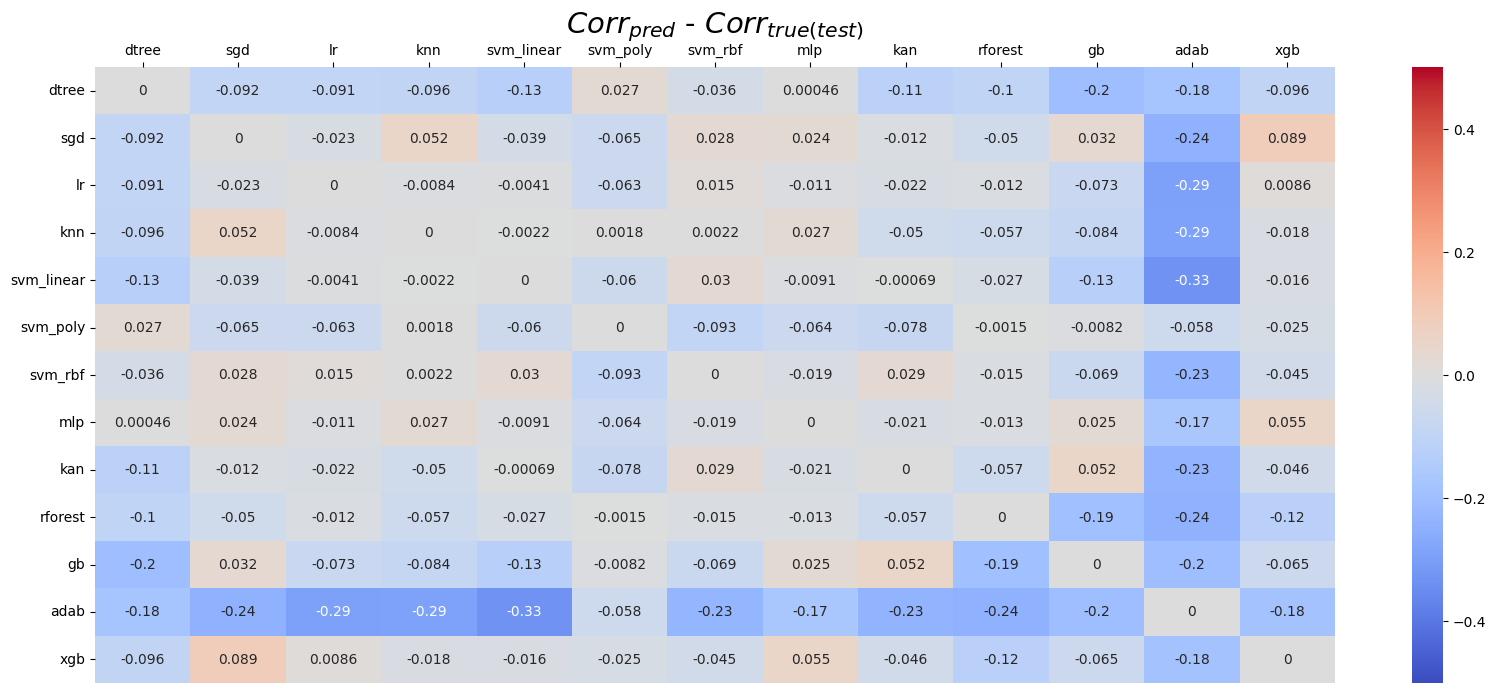

In [91]:
pred_corrls2 = ya_test.corr('pearson')
diff_corrls = mor_corrls - pred_corrls2

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()

## Individuais

In [92]:
ind_assessors = {}
parameters['criterion'] = ['squared_error', 'poisson', 'friedman_mse']

for i in range(len(models)):
    g_search = GridSearchCV(RandomForestRegressor(random_state=seed), parameters, cv=5, n_jobs=-1)
    ind_assessors[model_names[i]] = g_search.fit(Xa_train, ya_train[model_names[i]]).best_estimator_
    print(f'[Assessor {i}] | Modelo Base: {model_names[i]} | Parâmetros: {g_search.best_params_}\nScore: {g_search.best_score_:.4f}\n')

[Assessor 0] | Modelo Base: dtree | Parâmetros: {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Score: 0.0275

[Assessor 1] | Modelo Base: sgd | Parâmetros: {'criterion': 'squared_error', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Score: 0.1356

[Assessor 2] | Modelo Base: lr | Parâmetros: {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Score: 0.1376

[Assessor 3] | Modelo Base: knn | Parâmetros: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 20}
Score: -0.0005

[Assessor 4] | Modelo Base: svm_linear | Parâmetros: {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Score: 0.1129

[Assessor 5] | Modelo Base: svm_poly | Parâmetros: {'criterion': 'squared_error', 'max_depth': None, 'min_sampl

In [93]:
metrics_indv = {'MSE':[], 'RMSE':[], 'MAE':[], 'NMSE':[]}

for m in model_names:
    y_pred = ind_assessors[m].predict(Xa_test)

    # Cálculo das métricas
    metrics_indv['MSE'].append(mse(ya_test[m], y_pred))
    metrics_indv['RMSE'].append(rmse(ya_test[m], y_pred))
    metrics_indv['MAE'].append(mae(ya_test[m], y_pred))
    metrics_indv['NMSE'].append(nmse(ya_test[m], y_pred))


    mse_df.at['individual',m] = mse(ya_test[m], y_pred)
    rmse_df.at['individual',m] = rmse(ya_test[m], y_pred)
    mae_df.at['individual',m] = mae(ya_test[m], y_pred)
    nmse_df.at['individual',m] = nmse(ya_test[m], y_pred)

for k in metrics_indv.keys():
    print(f'''{k}:
    - Média: {np.mean(metrics_indv[k]):.4f}
    - DP:    {np.std(metrics_indv[k]):.4f}''')

mse_df

MSE:
    - Média: 0.0674
    - DP:    0.0339
RMSE:
    - Média: 0.2519
    - DP:    0.0627
MAE:
    - Média: 0.1970
    - DP:    0.0492
NMSE:
    - Média: 1.0174
    - DP:    0.1003


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain      0.091869  0.094910  0.044858  0.049381    0.050228  0.044900   
multi-output  0.091869  0.101868  0.046417  0.049038    0.052273  0.048239   
individual    0.093350  0.100006  0.047054  0.047498    0.051631  0.048239   

               svm_rbf       mlp       kan   rforest        gb      adab  \
regchain      0.054480  0.077139  0.155929  0.040937  0.052039  0.019820   
multi-output  0.057327  0.077955  0.175583  0.044409  0.053460  0.020026   
individual    0.057839  0.075726  0.156486  0.042937  0.051187  0.017546   

                   xgb  
regchain      0.105312  
multi-output  0.101638  
individual    0.086256

#### Análise das correlações

Conjunto de Treinamento:

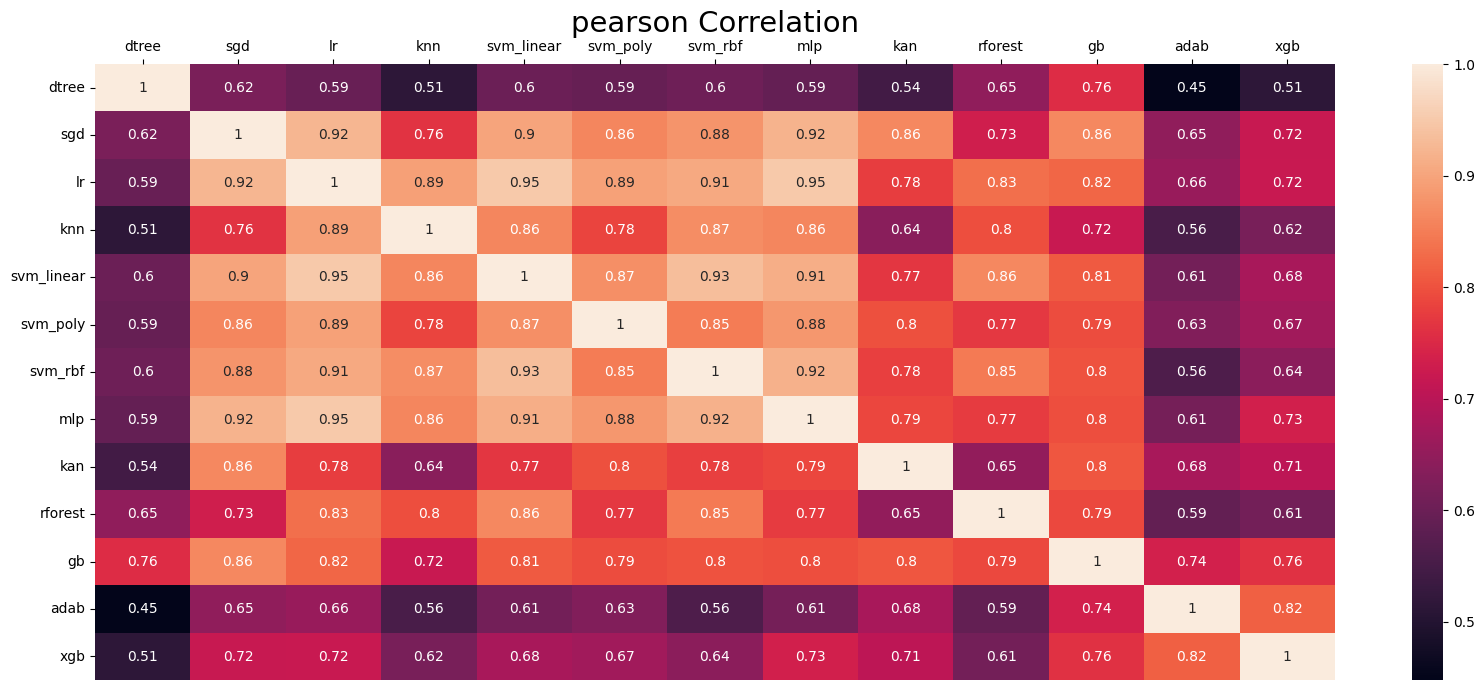

            corr
count  78.000000
mean    0.748826
std     0.123215
min     0.447713
25%     0.642650
50%     0.772119
75%     0.860028
max     0.948730


<Axes: >

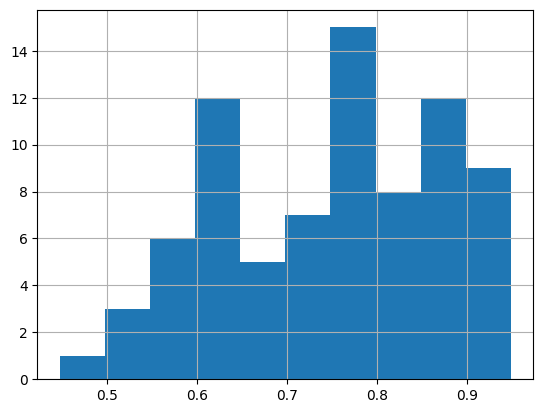

In [153]:
#y_pred = pd.DataFrame(columns=model_names)

indass_corrls = pd.DataFrame(columns=model_names, 
                             index=Xa_train.index, dtype=float)

for m in model_names:
    indass_corrls[m] = ind_assessors[m].predict(Xa_train)

indass_corrls = indass_corrls.corr('pearson')
plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(indass_corrls, annot=True)
hm.xaxis.tick_top()
plt.show()

indass_corrls_values = indass_corrls.reset_index().melt(id_vars='index', var_name='model2', value_name='corr')
indass_corrls_values = indass_corrls_values.rename(columns={'index': 'model1'})
indass_corrls_values = indass_corrls_values[indass_corrls_values['model1']!=indass_corrls_values['model2']].reset_index(drop=True)
# ordenando strings por linha
indass_corrls_values.loc[:,['model1','model2']] = pd.DataFrame(np.sort(indass_corrls_values.loc[:,['model1','model2']].values, axis=1), columns=['model1','model2']) 
indass_corrls_values = indass_corrls_values.drop_duplicates().reset_index(drop=True)

print(indass_corrls_values[['corr']].describe())

indass_corrls_values['corr'].hist()

In [154]:
min_score5 = indass_corrls_values['corr'].quantile(0.75)

print('Min_score:', min_score5)

groups['indv_assessor_train'] = group_search(indass_corrls, min_score5)
groups['indv_assessor_train']

Min_score: 0.8600278718746879


[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear', 'svm_poly'],
 ['lr', 'mlp', 'sgd', 'svm_linear', 'svm_rbf'],
 ['kan', 'sgd'],
 ['gb', 'sgd'],
 ['knn', 'lr', 'mlp', 'svm_rbf'],
 ['rforest', 'svm_linear'],
 ['adab'],
 ['xgb']]

Conjunto de Teste:

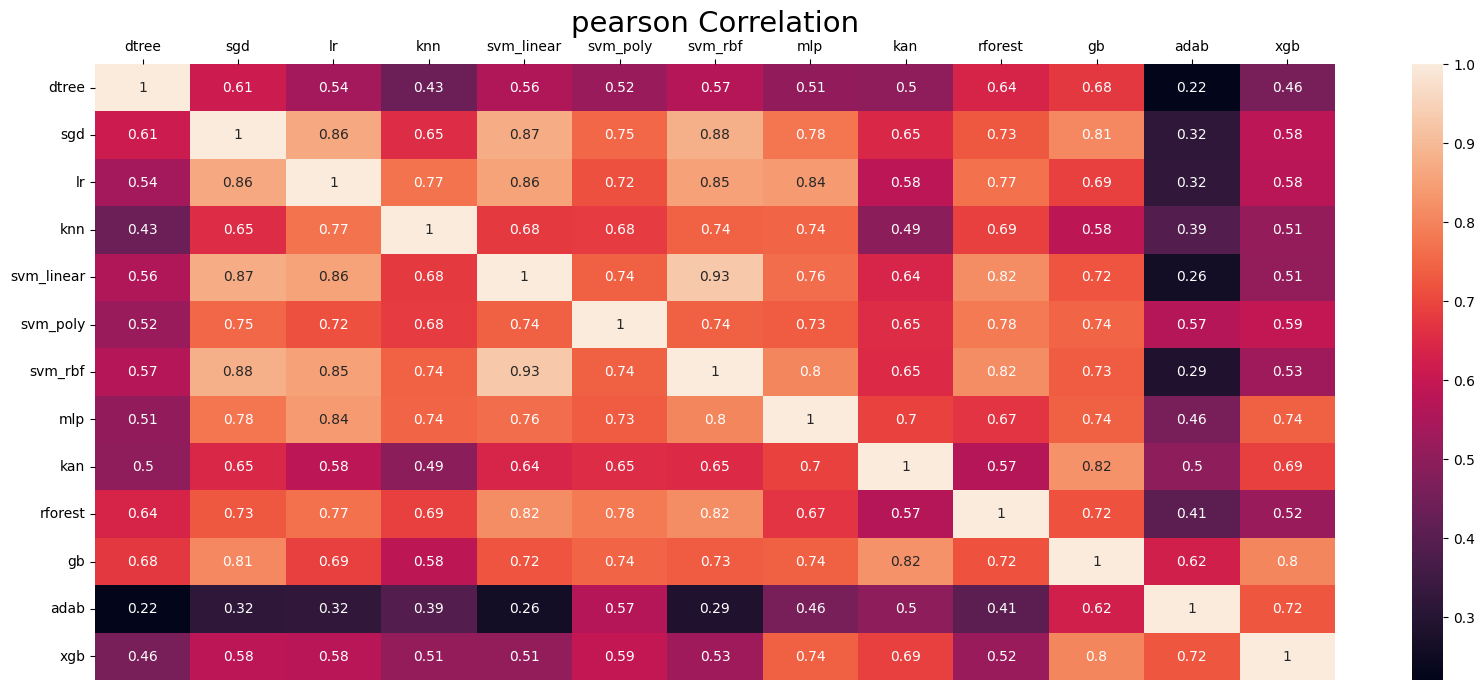

            corr
count  78.000000
mean    0.644390
std     0.155753
min     0.220624
25%     0.540842
50%     0.677001
75%     0.744855
max     0.928428


<Axes: >

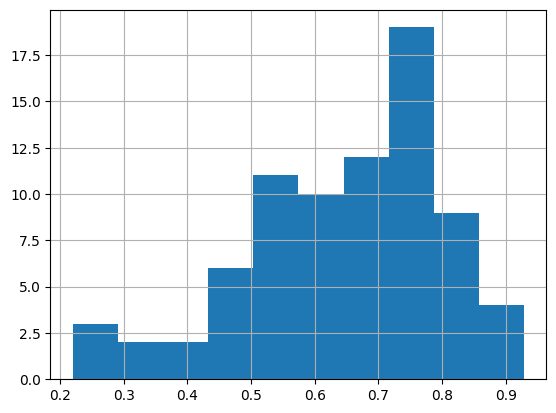

In [155]:
indass_corrls = pd.DataFrame(columns=model_names, 
                             index=Xa_test.index, dtype=float)

for m in model_names:
    indass_corrls[m] = ind_assessors[m].predict(Xa_test)

indass_corrls = indass_corrls.corr('pearson')
plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(indass_corrls, annot=True)
hm.xaxis.tick_top()
plt.show()

indass_corrls_values = indass_corrls.reset_index().melt(id_vars='index', var_name='model2', value_name='corr')
indass_corrls_values = indass_corrls_values.rename(columns={'index': 'model1'})
indass_corrls_values = indass_corrls_values[indass_corrls_values['model1']!=indass_corrls_values['model2']].reset_index(drop=True)
# ordenando strings por linha
indass_corrls_values.loc[:,['model1','model2']] = pd.DataFrame(np.sort(indass_corrls_values.loc[:,['model1','model2']].values, axis=1), columns=['model1','model2']) 
indass_corrls_values = indass_corrls_values.drop_duplicates().reset_index(drop=True)

print(indass_corrls_values[['corr']].describe())

indass_corrls_values['corr'].hist()

In [156]:
min_score5 = indass_corrls_values['corr'].quantile(0.75)

print('Min_score:', min_score5)

groups['indv_assessor_test'] = group_search(indass_corrls, min_score5)
groups['indv_assessor_test']

Min_score: 0.7448545115196976


[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear', 'svm_rbf'],
 ['gb', 'sgd', 'svm_poly'],
 ['knn', 'lr'],
 ['lr', 'rforest', 'svm_linear', 'svm_rbf'],
 ['rforest', 'svm_poly'],
 ['gb', 'kan'],
 ['gb', 'xgb'],
 ['adab']]

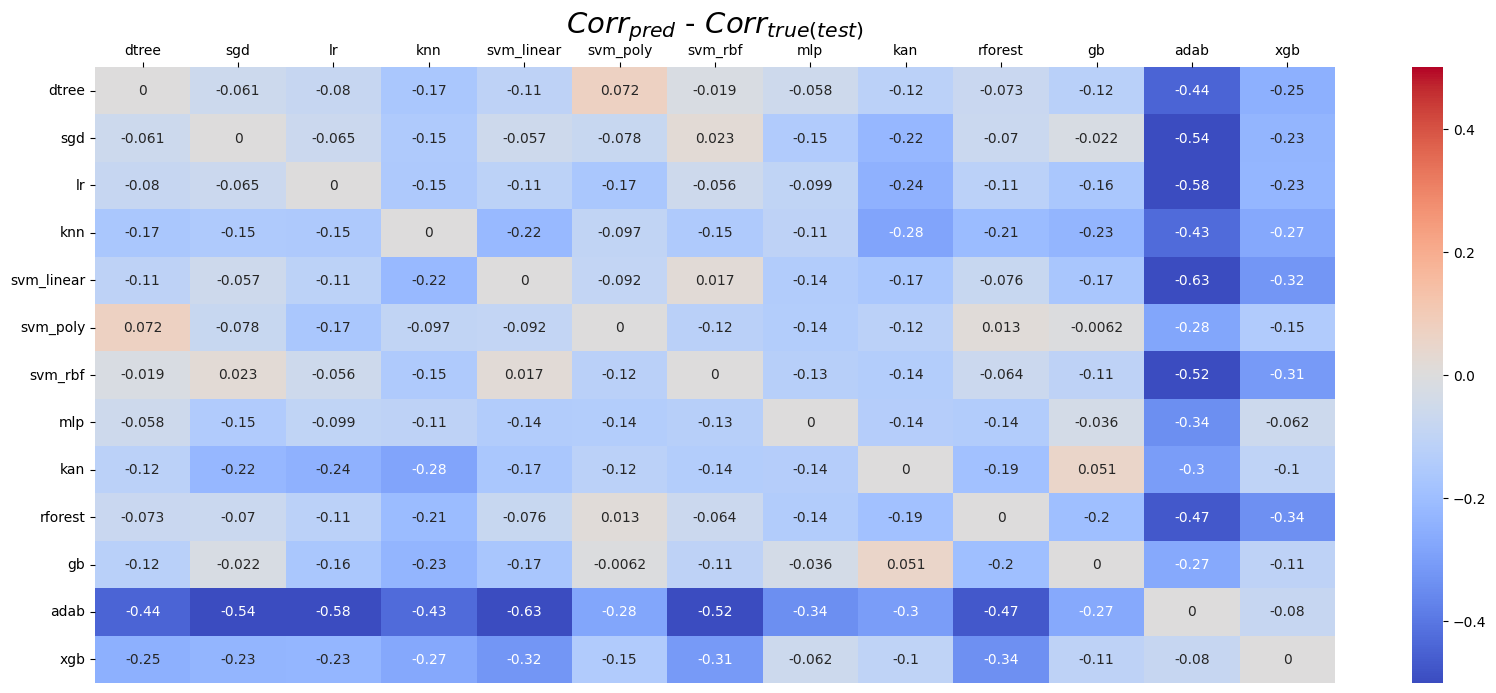

In [157]:
#pred_corrls2 = ya_test.corr('pearson')
diff_corrls = indass_corrls - pred_corrls2

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()

## Grupais

In [158]:
keys = list(groups.keys())
for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        print(f'{keys[i]}({len(groups[keys[i]])}) & {keys[j]}({len(groups[keys[j]])}):')
        count = 0
        for g in groups[keys[i]]:
            if(g in groups[keys[j]]):
                print(g)
                count += 1
        print(f'Número de grupos em comum: {count}\n\n')

true_assessor_train(8) & true_assessor_test(11):
['dtree']
['gb', 'xgb']
Número de grupos em comum: 2


true_assessor_train(8) & regchain_assessor_train(9):
['dtree']
['adab']
Número de grupos em comum: 2


true_assessor_train(8) & regchain_assessor_test(8):
Número de grupos em comum: 0


true_assessor_train(8) & mor_assessor_train(9):
['dtree']
['lr', 'mlp', 'sgd', 'svm_linear', 'svm_rbf']
['kan', 'sgd']
['gb', 'xgb']
['adab']
Número de grupos em comum: 5


true_assessor_train(8) & mor_assessor_test(9):
['dtree']
['lr', 'mlp', 'sgd', 'svm_linear', 'svm_rbf']
['kan', 'sgd']
['adab']
Número de grupos em comum: 4


true_assessor_train(8) & indv_assessor_train(9):
['dtree']
['lr', 'mlp', 'sgd', 'svm_linear', 'svm_rbf']
['kan', 'sgd']
['adab']
Número de grupos em comum: 4


true_assessor_train(8) & indv_assessor_test(9):
['dtree']
['lr', 'mlp', 'sgd', 'svm_linear', 'svm_rbf']
['gb', 'xgb']
['adab']
Número de grupos em comum: 4


true_assessor_test(11) & regchain_assessor_train(9):
['dtree'

In [162]:
for g in groups['true_assessor_train']:
    if(len(g)!=1):
        teste = []
        for i, m in enumerate(g):
            for n in g[i+1:]:
                teste.append(pred_corrls.loc[m,n])
        print(g)
        print(f'total: {np.mean(teste)}\n')

['lr', 'mlp', 'sgd', 'svm_linear', 'svm_rbf']
total: 0.9258025663125761

['kan', 'sgd']
total: 0.8597578523693278

['knn', 'lr', 'svm_rbf']
total: 0.8940378011434739

['lr', 'mlp', 'svm_linear', 'svm_poly', 'svm_rbf']
total: 0.910517893051396

['lr', 'rforest', 'svm_linear']
total: 0.9048887401689303

['gb', 'xgb']
total: 0.865231599455681



In [163]:
groups

{'true_assessor_train': [['dtree'],
  ['lr', 'mlp', 'sgd', 'svm_linear', 'svm_rbf'],
  ['kan', 'sgd'],
  ['knn', 'lr', 'svm_rbf'],
  ['lr', 'mlp', 'svm_linear', 'svm_poly', 'svm_rbf'],
  ['lr', 'rforest', 'svm_linear'],
  ['gb', 'xgb'],
  ['adab']],
 'true_assessor_test': [['dtree'],
  ['lr', 'mlp', 'sgd', 'svm_linear'],
  ['knn', 'lr', 'svm_linear', 'svm_rbf'],
  ['lr', 'mlp', 'svm_linear', 'svm_rbf'],
  ['adab', 'lr', 'svm_linear'],
  ['knn', 'rforest', 'svm_linear'],
  ['gb', 'rforest', 'svm_linear'],
  ['adab', 'gb', 'svm_linear'],
  ['svm_poly'],
  ['kan'],
  ['gb', 'xgb']],
 'regchain_assessor_train': [['dtree'],
  ['lr', 'sgd', 'svm_linear', 'svm_poly'],
  ['lr', 'mlp', 'sgd', 'svm_linear'],
  ['knn', 'lr', 'mlp', 'svm_linear', 'svm_rbf'],
  ['knn', 'rforest', 'svm_linear', 'svm_rbf'],
  ['gb', 'svm_rbf'],
  ['kan'],
  ['adab'],
  ['xgb']],
 'regchain_assessor_test': [['adab', 'dtree'],
  ['knn', 'lr', 'mlp', 'sgd', 'svm_linear'],
  ['knn', 'lr', 'mlp', 'svm_linear', 'svm_rbf'],

### Regressor Chain

In [109]:
regchain4groups = []

for g in groups['true_assessor_train']:
    model = RegressorChain(RandomForestRegressor(random_state=seed), verbose=False, random_state=seed, cv=5).fit(Xa_train, ya_train[g])
    regchain4groups.append(model)

In [123]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = regchain4groups[i].predict(Xa_test)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

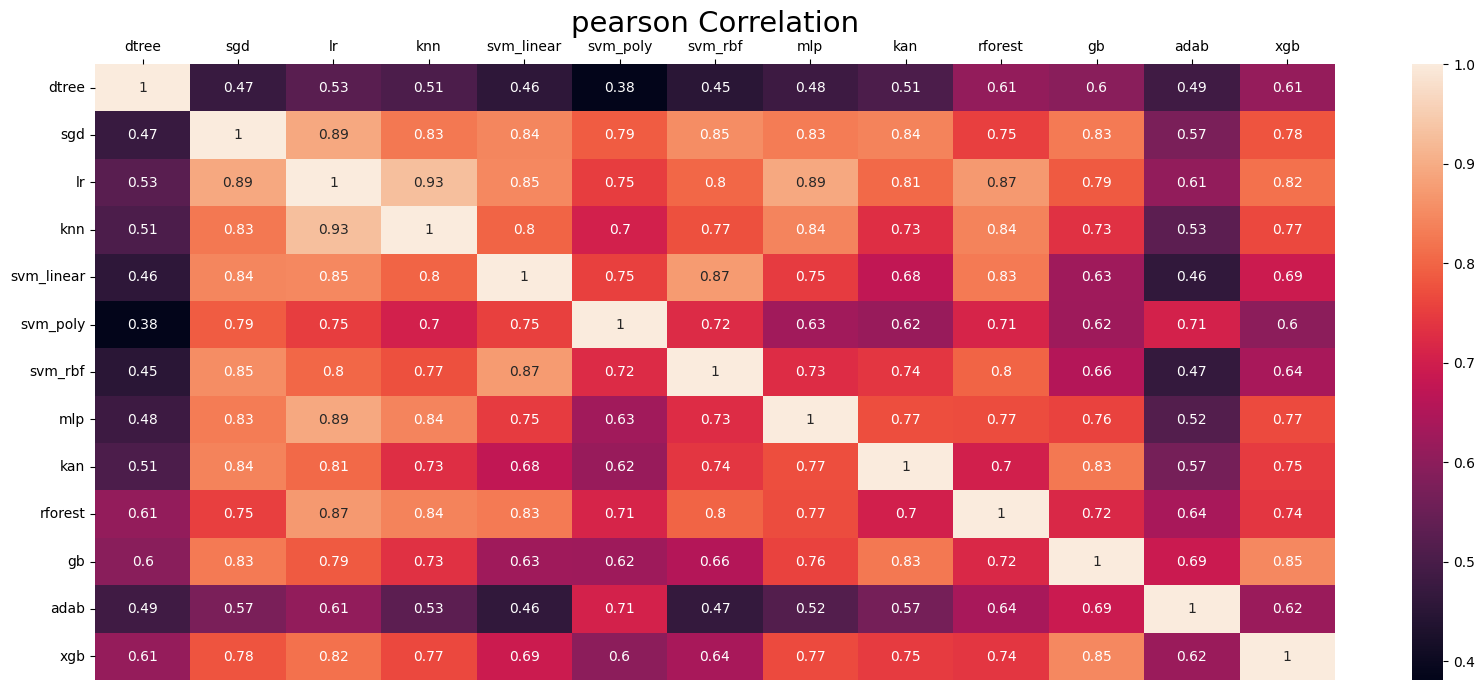

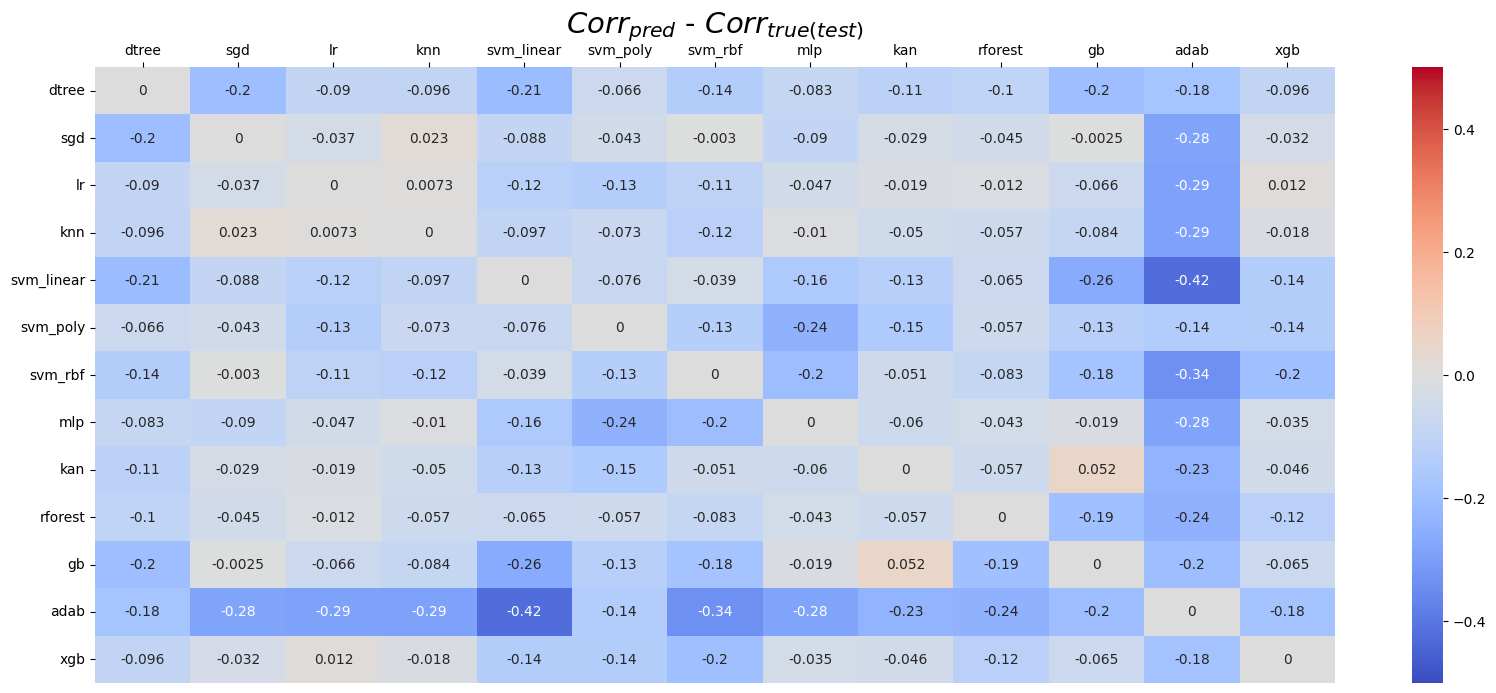

In [111]:
regchainGroups_corrls = y_pred.corr('pearson')
pred_corrls2 = ya_test.corr('pearson')

plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(regchainGroups_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

diff_corrls = regchainGroups_corrls - pred_corrls2

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

In [124]:
print(f'''MSE: {mse(ya_test, y_pred):.4f}
RMSE: {rmse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}''')

mse_df.loc['regchain(group)',:] = mse_models(ya_test, y_pred)
rmse_df.loc['regchain(group)',:] = rmse_models(ya_test, y_pred)
mae_df.loc['regchain(group)',:] = mae_models(ya_test, y_pred)
nmse_df.loc['regchain(group)',:] = nmse_models(ya_test, y_pred)

mse_df

MSE: 0.0692
RMSE: 0.2546
MAE: 0.1988
NMSE: 1.0377


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain         0.091869  0.094910  0.044858  0.049381    0.050228  0.044900   
multi-output     0.091869  0.101868  0.046417  0.049038    0.052273  0.048239   
individual       0.093350  0.100006  0.047054  0.047498    0.051631  0.048239   
regchain(group)  0.091869  0.089725  0.045282  0.049038    0.049828  0.050739   

                  svm_rbf       mlp       kan   rforest        gb      adab  \
regchain         0.054480  0.077139  0.155929  0.040937  0.052039  0.019820   
multi-output     0.057327  0.077955  0.175583  0.044409  0.053460  0.020026   
individual       0.057839  0.075726  0.156486  0.042937  0.051187  0.017546   
regchain(group)  0.052210  0.075249  0.175583  0.044409  0.053460  0.020026   

                      xgb  
regchain         0.105312  
multi-output     0.101638  
individual       0.086256  
regchain(group)  0.101638

### Multi-Output Regressor

In [113]:
mor4groups = []

for g in groups['true_assessor_train']:
    model = MultiOutputRegressor(RandomForestRegressor(random_state=seed), n_jobs=-1).fit(Xa_train, ya_train[g])
    mor4groups.append(model)

In [125]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = mor4groups[i].predict(Xa_test)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

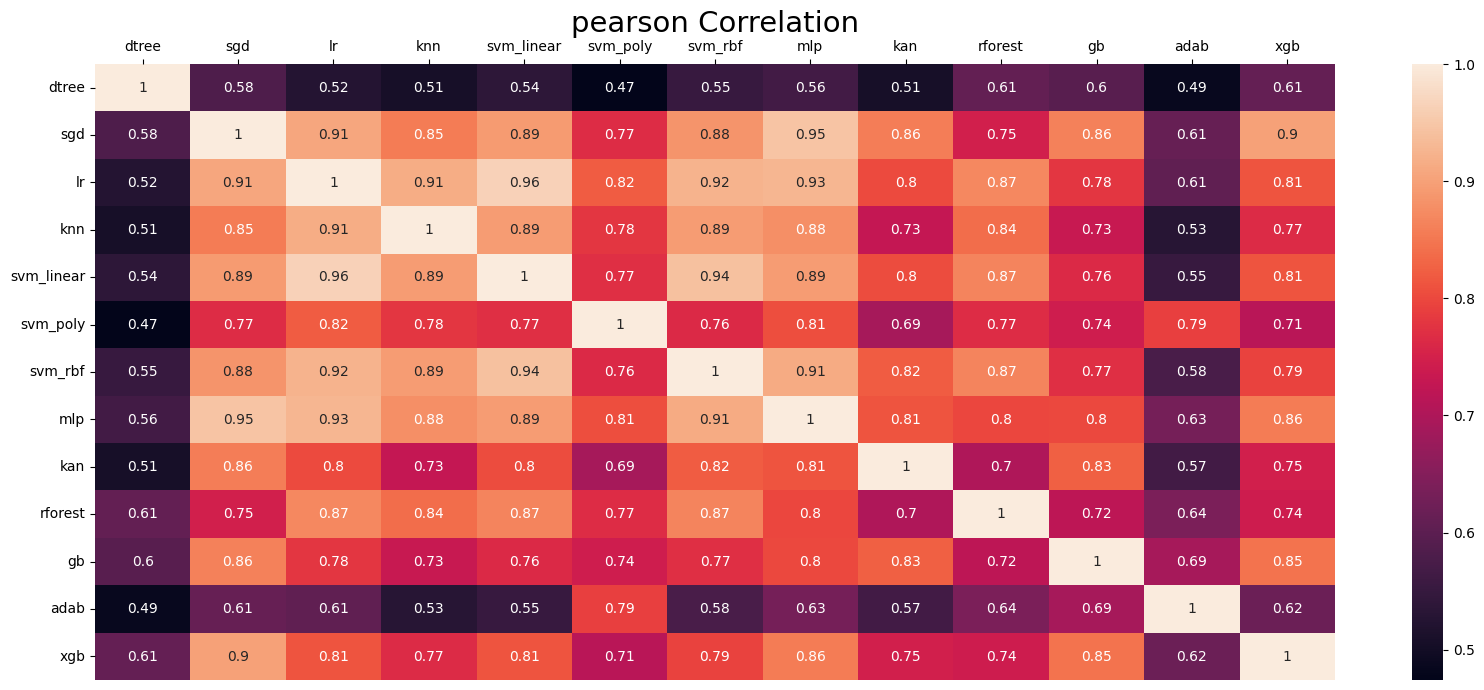

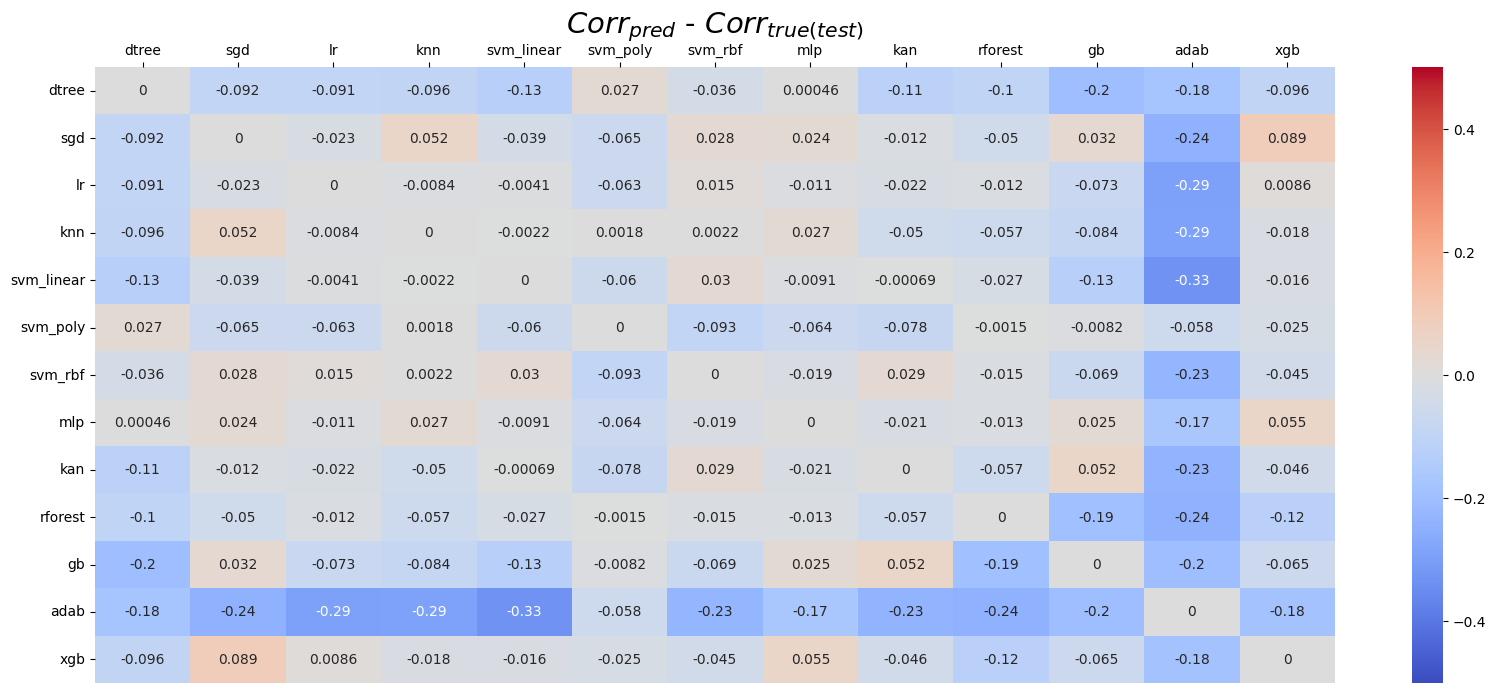

In [115]:
morGroups_corrls = y_pred.corr('pearson')
#pred_corrls2 = ya_test.corr('pearson')

plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(morGroups_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

diff_corrls = morGroups_corrls - pred_corrls2

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

In [126]:
print(f'''MSE: {mse(ya_test, y_pred):.4f}
RMSE: {rmse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}''')

mse_df.loc['multi-output(group)',:] = mse_models(ya_test, y_pred)
rmse_df.loc['multi-output(group)',:] = rmse_models(ya_test, y_pred)
mae_df.loc['multi-output(group)',:] = mae_models(ya_test, y_pred)
nmse_df.loc['multi-output(group)',:] = nmse_models(ya_test, y_pred)

mse_df

MSE: 0.0708
RMSE: 0.2575
MAE: 0.1995
NMSE: 1.0609


dtree       sgd        lr       knn  svm_linear  \
regchain             0.091869  0.094910  0.044858  0.049381    0.050228   
multi-output         0.091869  0.101868  0.046417  0.049038    0.052273   
individual           0.093350  0.100006  0.047054  0.047498    0.051631   
regchain(group)      0.091869  0.089725  0.045282  0.049038    0.049828   
multi-output(group)  0.091869  0.101868  0.046417  0.049038    0.052273   

                     svm_poly   svm_rbf       mlp       kan   rforest  \
regchain             0.044900  0.054480  0.077139  0.155929  0.040937   
multi-output         0.048239  0.057327  0.077955  0.175583  0.044409   
individual           0.048239  0.057839  0.075726  0.156486  0.042937   
regchain(group)      0.050739  0.052210  0.075249  0.175583  0.044409   
multi-output(group)  0.048239  0.057327  0.077955  0.175583  0.044409   

                           gb      adab       xgb  
regchain             0.052039  0.019820  0.105312  
multi-output         0.053460  0.020026  0.101638  
individual           0.051187  0.017546  0.086256  
regchain(group)      0.053460  0.020026  0.101638  
multi-output(group)  0.053460  0.020026  0.101638

## Análises

In [117]:
def metricsFormat(df: pd.DataFrame, metric_name:str):
    df = df.reset_index().melt(id_vars='index', var_name='model', value_name=metric_name)
    df = df.rename(columns={'index': 'assessor_type'})

    return df

In [127]:
metrics_df = metricsFormat(mse_df, 'MSE')

metrics_df = pd.merge(metrics_df, metricsFormat(rmse_df, 'RMSE'), how='inner', on=['assessor_type', 'model'])

metrics_df = pd.merge(metrics_df, metricsFormat(mae_df, 'MAE'), how='inner', on=['assessor_type', 'model'])

metrics_df = pd.merge(metrics_df, metricsFormat(nmse_df, 'NMSE'), how='inner', on=['assessor_type', 'model'])

metrics_df

assessor_type  model       MSE      RMSE       MAE      NMSE
0              regchain  dtree  0.091869  0.303099  0.227641  0.914335
1          multi-output  dtree  0.091869  0.303099  0.227641  0.914335
2            individual  dtree  0.093350  0.305533  0.231295  0.929076
3       regchain(group)  dtree  0.091869  0.303099  0.227641  0.914335
4   multi-output(group)  dtree  0.091869  0.303099  0.227641  0.914335
..                  ...    ...       ...       ...       ...       ...
60             regchain    xgb  0.105312  0.324517  0.247599  1.128666
61         multi-output    xgb  0.101638  0.318808  0.244208  1.089298
62           individual    xgb  0.086256  0.293694  0.229022  0.924442
63      regchain(group)    xgb  0.101638  0.318808  0.244208  1.089298
64  multi-output(group)    xgb  0.101638  0.318808  0.244208  1.089298

[65 rows x 6 columns]

In [128]:
class_palette = [sns.color_palette()[0], sns.color_palette()[3], sns.color_palette()[2], sns.color_palette()[-1], sns.color_palette()[1]]

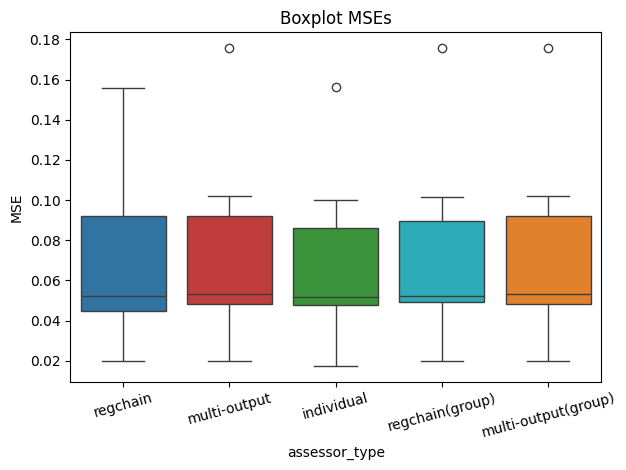

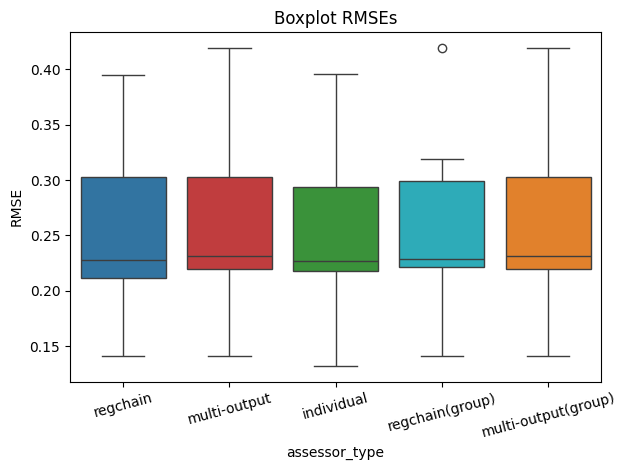

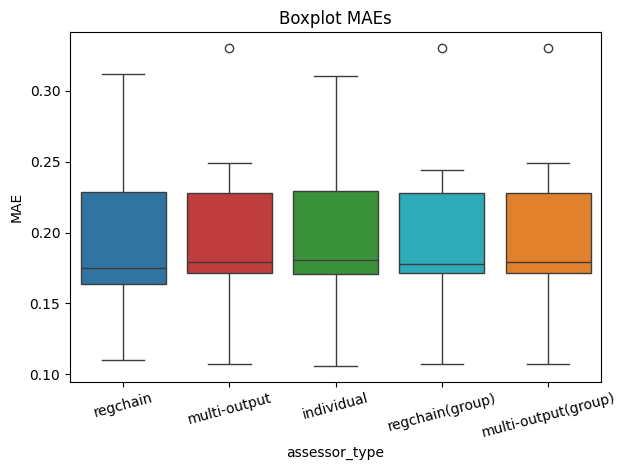

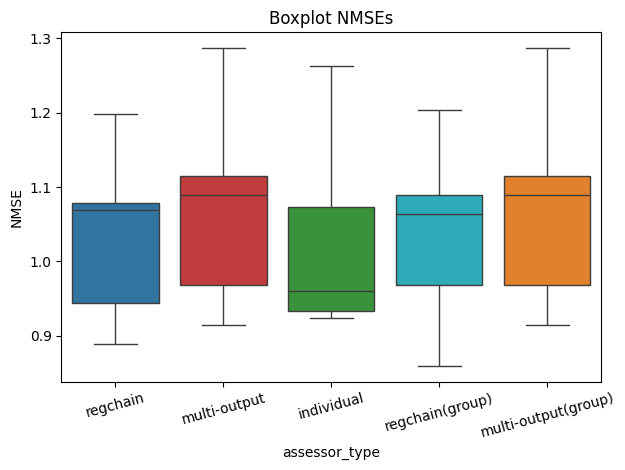

In [129]:
for mt in ['MSE', 'RMSE', 'MAE', 'NMSE']:
    plt.title(f'Boxplot {mt}s')
    sns.boxplot(metrics_df.loc[:,['assessor_type','model',mt]], y=mt, x='assessor_type', hue='assessor_type', palette=class_palette)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

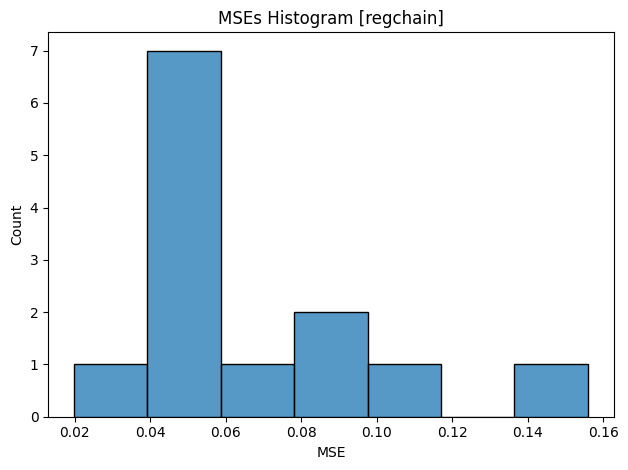

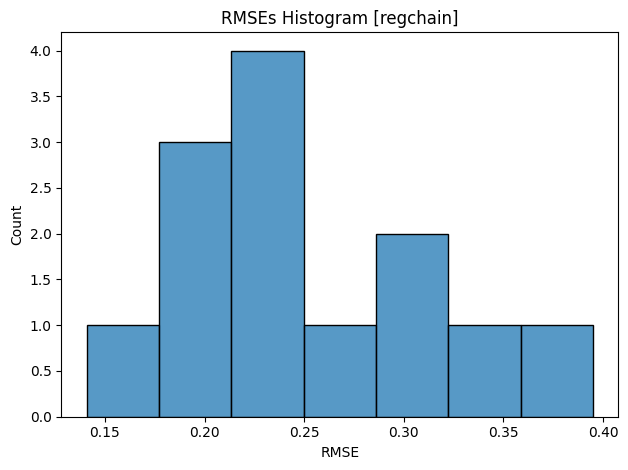

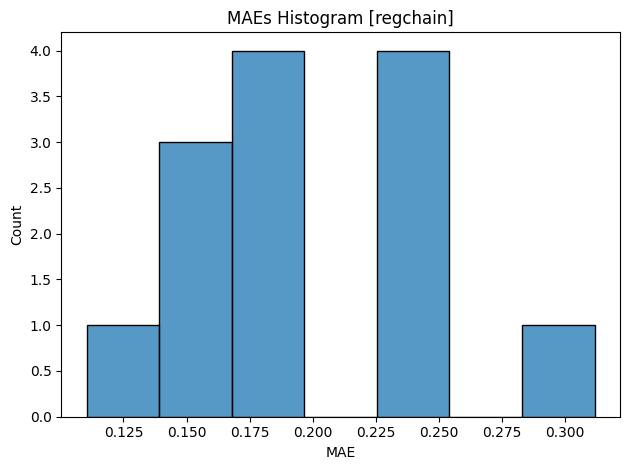

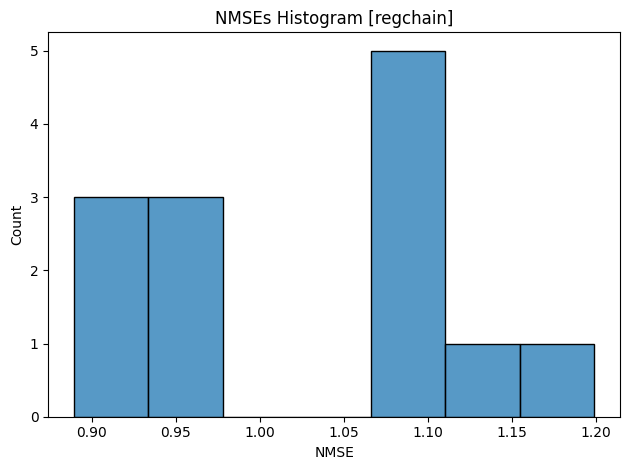

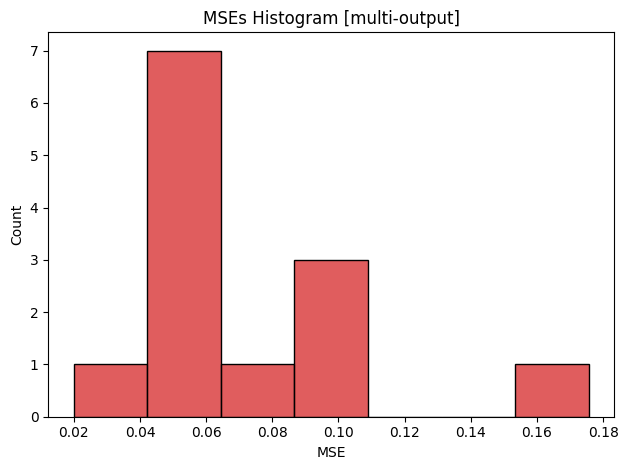

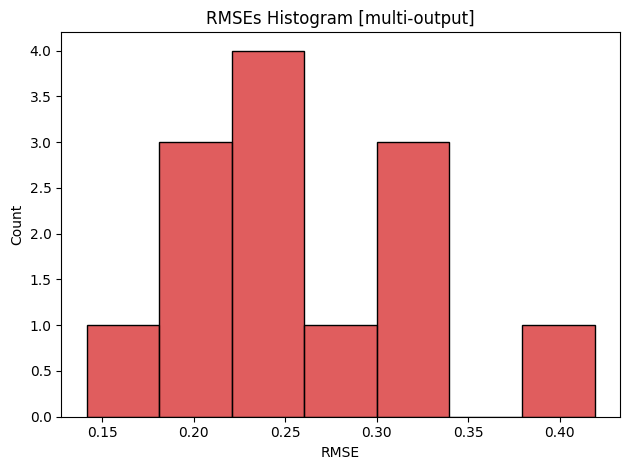

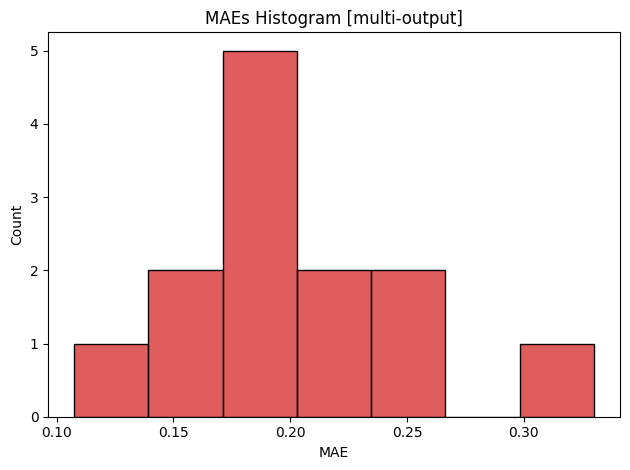

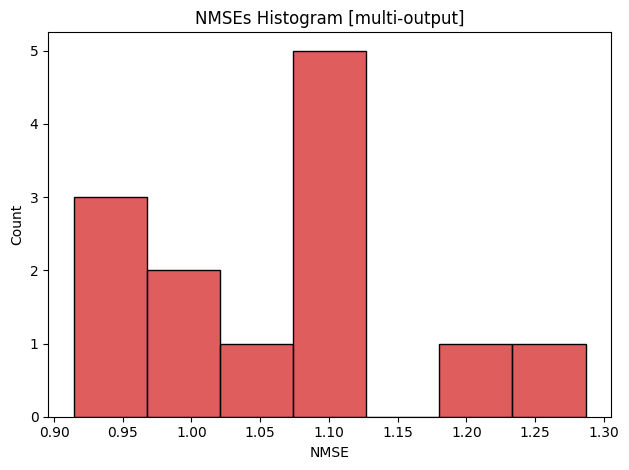

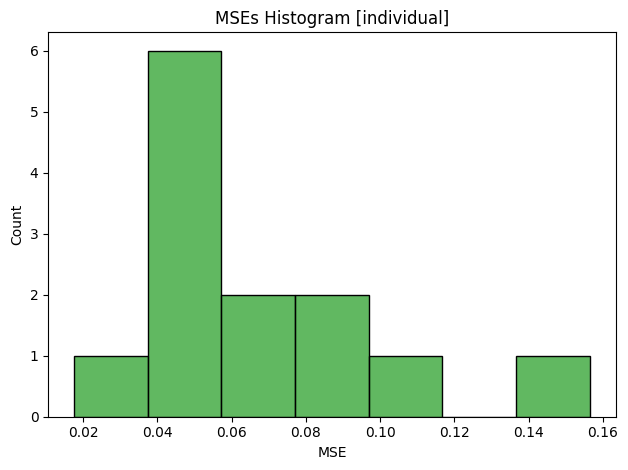

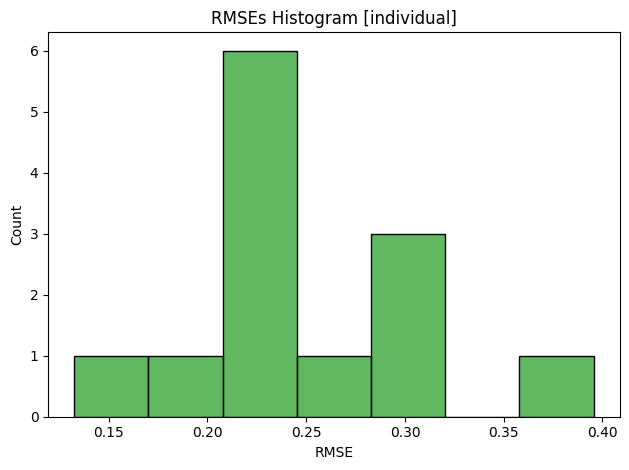

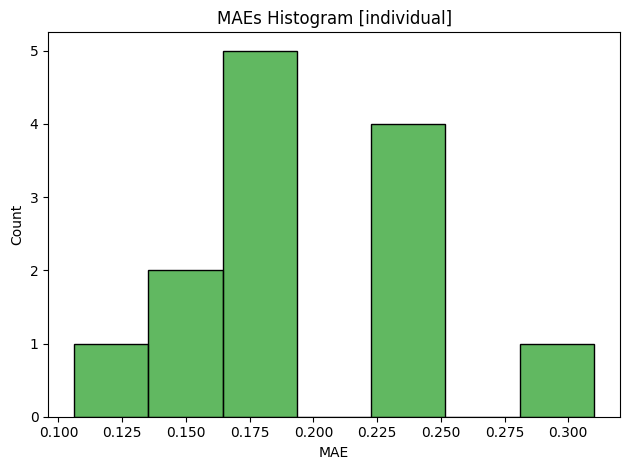

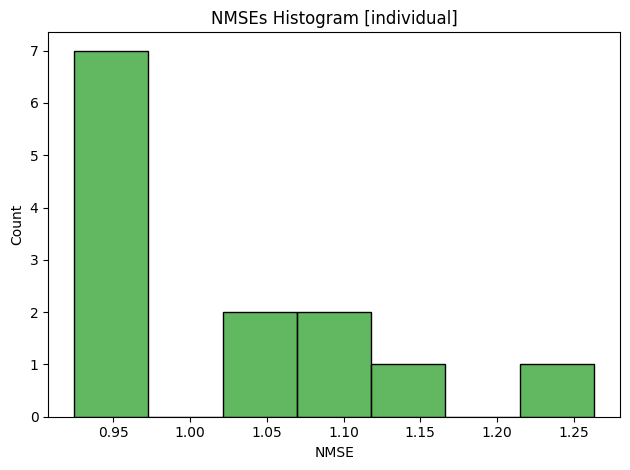

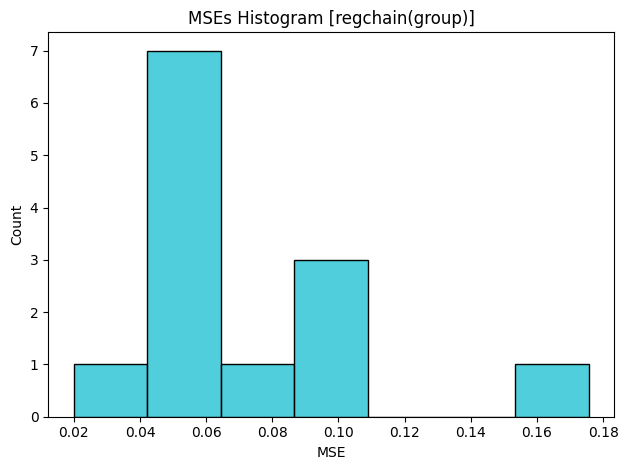

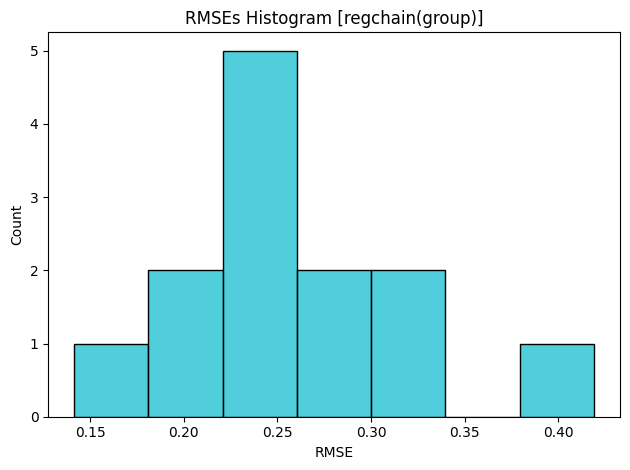

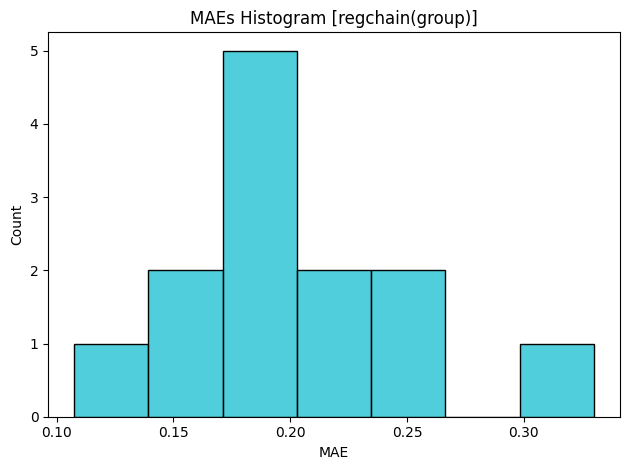

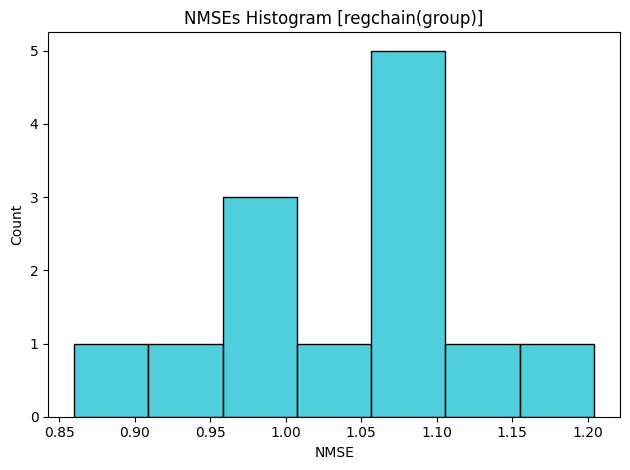

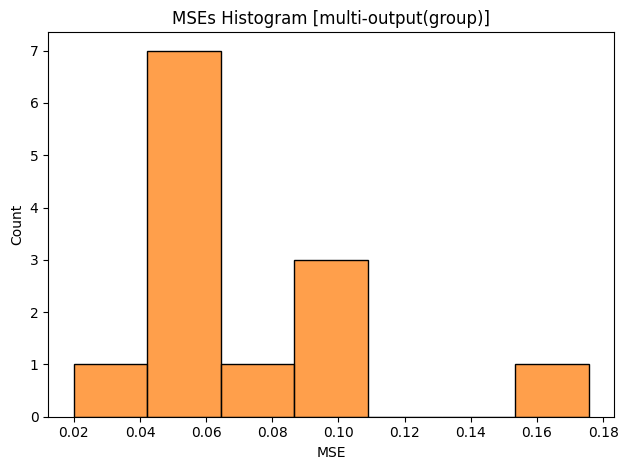

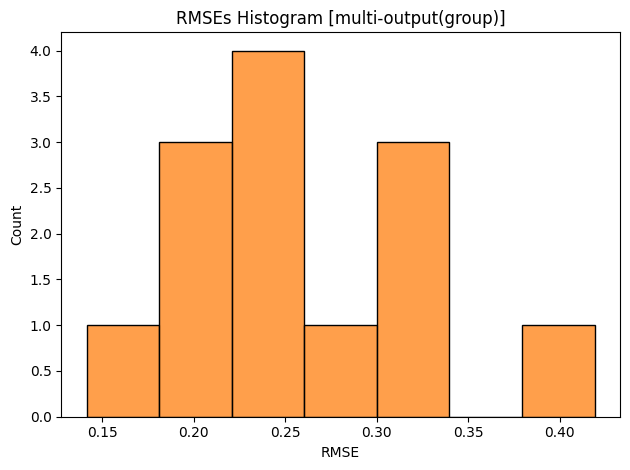

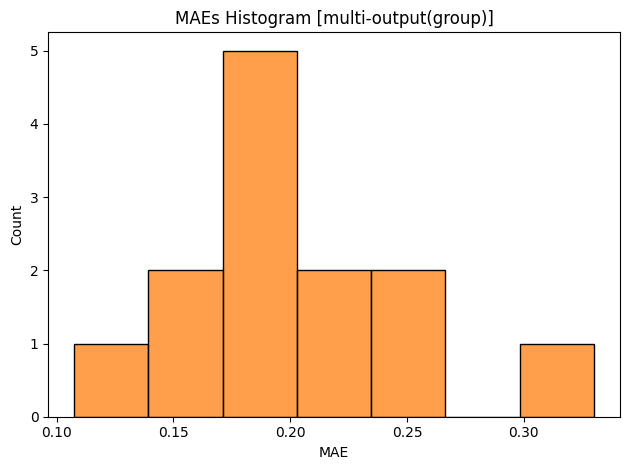

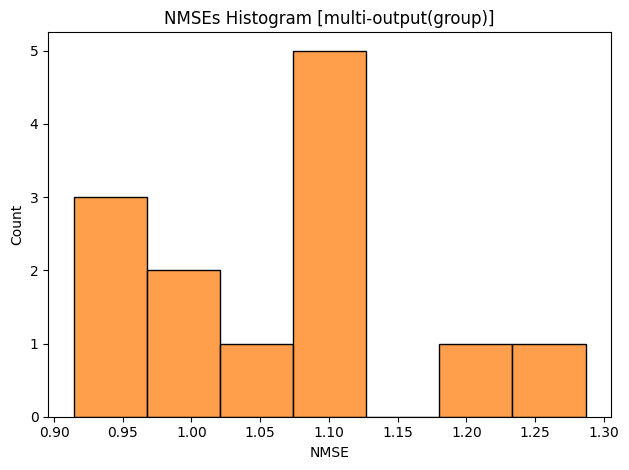

In [130]:
teste = {'regchain': class_palette[0], 
         'multi-output': class_palette[1], 
         'individual': class_palette[2],
         'regchain(group)': class_palette[3],
         'multi-output(group)': class_palette[4]}

for a in teste.keys():
    for mt in ['MSE', 'RMSE', 'MAE', 'NMSE']:
        plt.title(f'{mt}s Histogram [{a}]')
        sns.histplot(metrics_df.loc[metrics_df['assessor_type']==a,['assessor_type','model',mt]], x=mt, bins=7, color=teste[a])
        plt.tight_layout()
        plt.show()

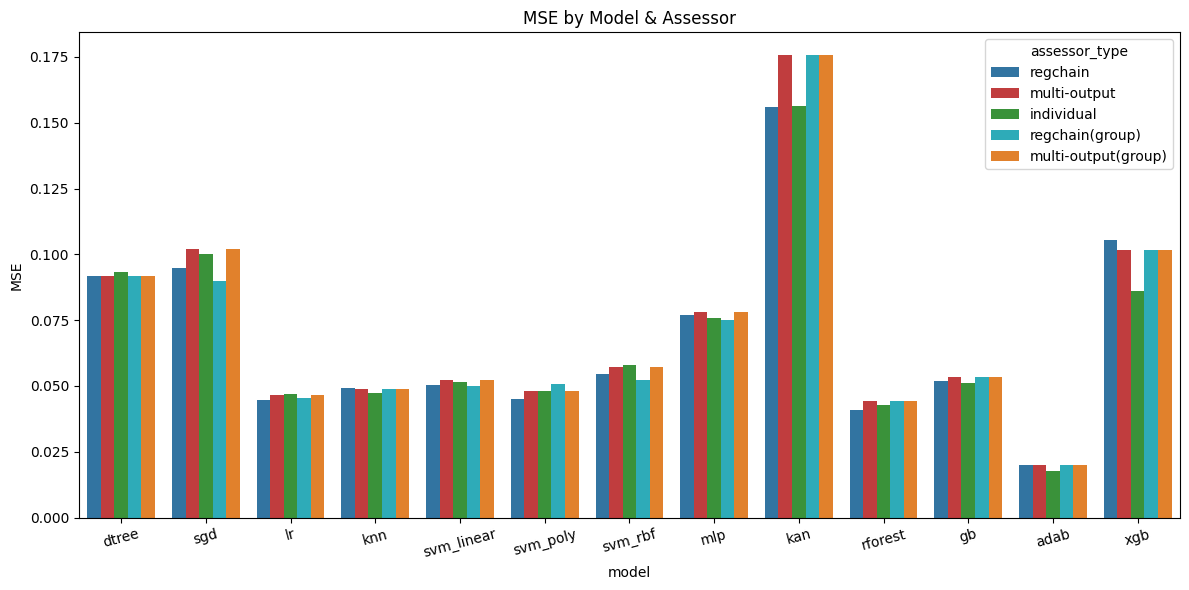

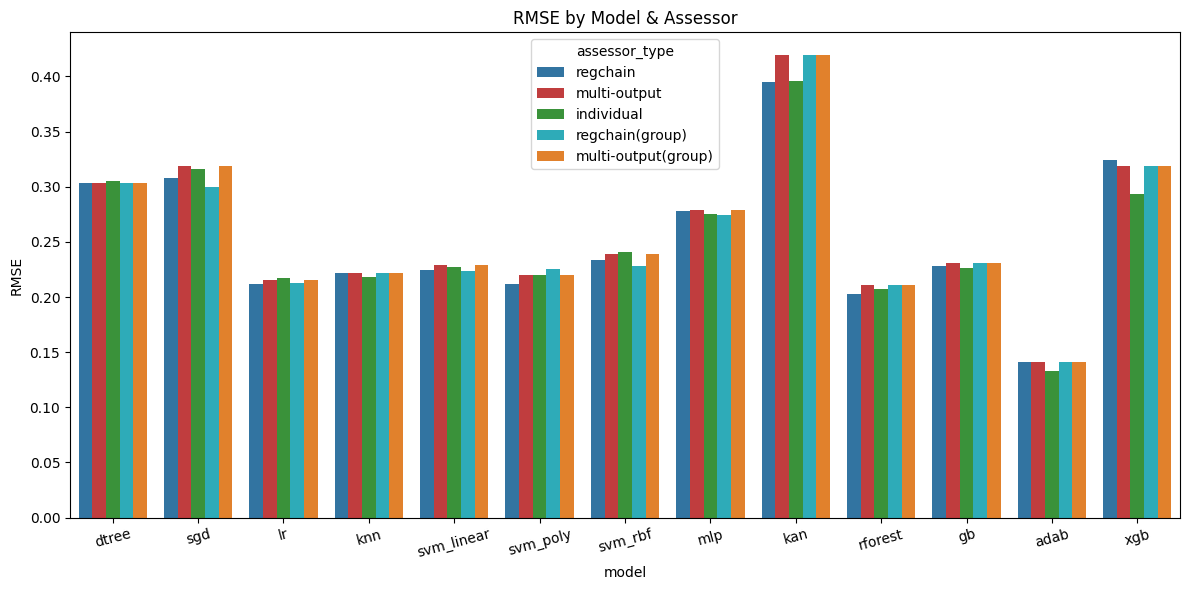

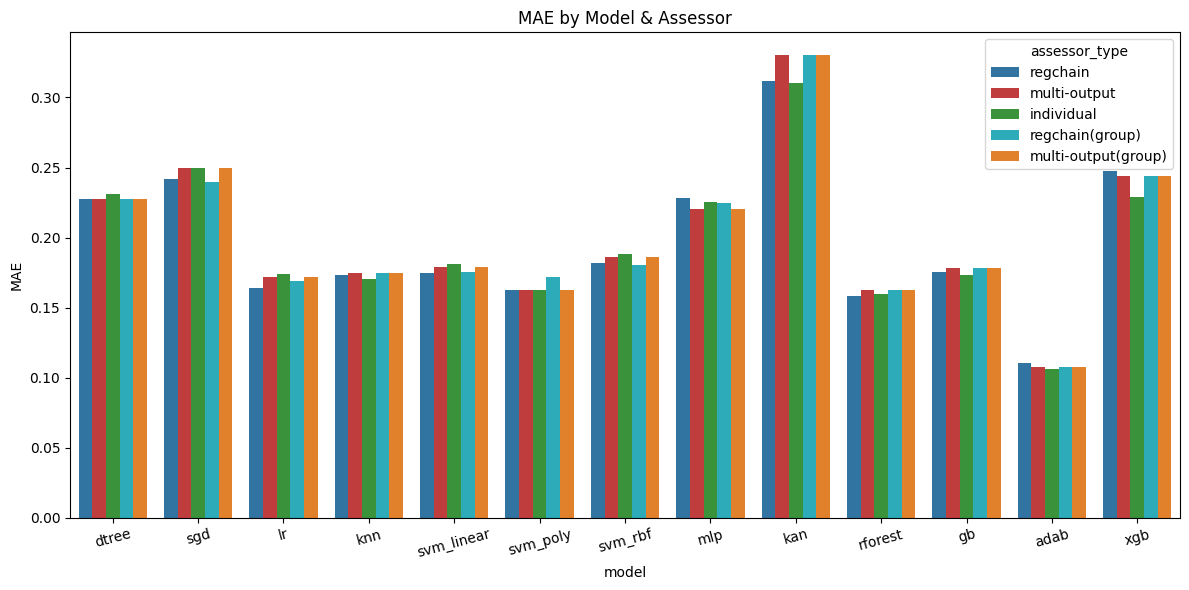

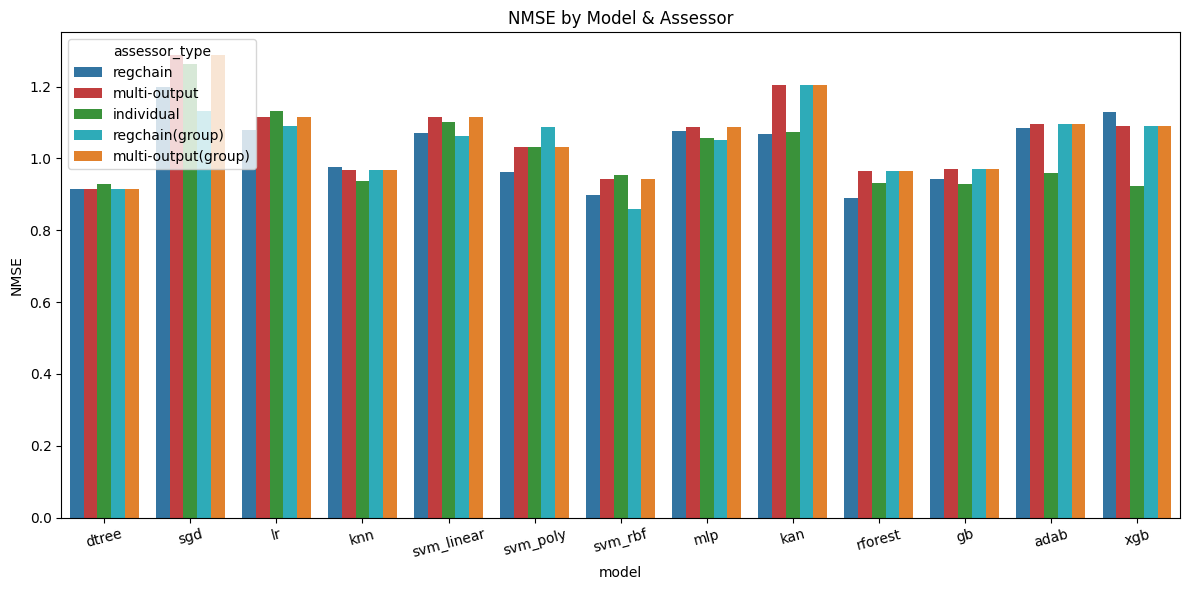

In [131]:
for mt in ['MSE', 'RMSE', 'MAE', 'NMSE']:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=metrics_df, x='model', y=mt, hue='assessor_type', palette=class_palette)
    plt.title(f'{mt} by Model & Assessor')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()